In [1]:
import os
import pynwb
import h5py
from tqdm import tqdm
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
import pywt
import matplotlib
import graph
import time

import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from ripple_detection import filter_ripple_band,Kay_ripple_detector

from scipy import signal
from scipy.fftpack import next_fast_len
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter1d
from scipy.signal import filtfilt, hilbert, remez, sosfiltfilt, butter

In [2]:
sz1 = 12
sz2 = 18
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
matplotlib.rc('xtick', labelsize=sz1) 
matplotlib.rc('ytick', labelsize=sz1) 
matplotlib.rc('axes', labelsize=sz1)  
matplotlib.rc('axes', titlesize=sz1)  
matplotlib.rc('figure', titlesize=sz2)
matplotlib.rc('legend', fontsize=sz1) 
matplotlib.rc('legend', title_fontsize=sz1)
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

In [3]:
def import_LFP(date):

    # get LFP data
    lfpFile = h5py.File('/Volumes/Extreme SSD/Teleworld/bart_I/raw/spikes/Bart_TeleWorld_v13_%s-spikes.mat' % date, 'r')
    timestamps = np.array(lfpFile['/lfpTimeStamps']).ravel()
    lfpData = lfpFile['/lfpTable']
    
    return timestamps, lfpData

In [4]:
def import_behavior(date):
    
    # get beh data
    DATA_DIR = Path('/Volumes/Extreme SSD')
    os.chdir(DATA_DIR)
    
    filename = 'Bart_TeleWorld_v13_%s.nwb' % date
    nwbfile = pynwb.NWBHDF5IO(filename, "r").read()

    return nwbfile

In [5]:
def import_ripple(date, band):
    
    data = np.load('/Users/lianghexin/Documents/Berkeley/Teleworld/Code/ripple band %i %i/session ripples %s %i to %i.npz' % 
                   (band[0], band[1], date, band[0], band[1]), allow_pickle=True)    
    all_peaks, _ = data['peaks'], data['durs']
    
    return all_peaks

In [6]:
def preprocess_LFP(lfp, cutoff=15, fs=1000):
    
    # remove 60Hz and harmonics
    
    preprocessed = lfp.copy()
    
    for f0 in [60, 120, 180, 240]:# design 10th order band-stop (Butterworth) filter for each noise frequency +/- 2 Hz
        notchfilt = butter(10, (f0-2,f0+2), 'bandstop', fs=fs, output='sos')
        preprocessed = sosfiltfilt(notchfilt, preprocessed)


    # detect big deflections, caused by banging or static electric noise etc. 
    
    diff = np.diff(preprocessed)
    zscored = (diff-diff.mean())/diff.std()
    noise, _ = signal.find_peaks(np.abs(zscored),height=cutoff)

    
    return preprocessed, noise

In [13]:
def detect_ripple(preprocessed, noise, band, fs=1000):

    # 1. bandpass, ripple band 150-250 (rat), NHP band 80-180
    
    sos = butter(5, band, btype='bandpass', output='sos', fs=fs)
    rippleband = sosfiltfilt(sos, preprocessed)

    
    # 2. calculate the power of ripple band
    
    envelope = np.abs(hilbert(rippleband))
    gauss_kernel = signal.windows.gaussian(101,20) # gaussian smoothing s.d. 12.5ms
    gauss_kernel /= gauss_kernel.sum()  # normalize
    smoothed = signal.convolve(envelope.ravel(),gauss_kernel,mode='same')

    
    # 3. replace noise with median
    
    median = np.median(smoothed)
    for nn in noise:
        smoothed[np.arange(nn-100,nn+100)] = median

    
    # 4, find local peaks > 3s.d. of the mean with minimal interval 50ms 
        
    zscored = (smoothed-smoothed.mean())/smoothed.std()
    candidate_peaks,_ = signal.find_peaks(zscored,height=3,distance=50)


    # 4. only keep peaks with >50ms width above 3sd
    true_peaks = []
    ons = []
    offs = []

    for _peak in candidate_peaks:

        if (_peak-500>0) & (_peak+500<len(zscored)):

            try:
                on = np.max(np.where(zscored[_peak-500:_peak]<3)[0]) + _peak - 500
                off = np.min(np.where(zscored[_peak:_peak+500]<3)[0]) + _peak
                    
                if off-on>50:
                    
                    true_peaks.append(_peak)
                    ons.append(on)
                    offs.append(off)
            except:
                pass

    true_peaks = np.array(true_peaks)
    ons = np.array(ons)
    offs = np.array(offs)

    return rippleband, smoothed, zscored, true_peaks, ons, offs

In [15]:
dates = ['031723','032023','032823','033123','040423','040723']
band = [150,250]

for date in dates:
    
    date_int = int(date[1:])
    
    timestamps, lfpData  = import_LFP(date)
    nwbfile = import_behavior(date)
    probe_info = pd.read_excel('/Users/lianghexin/Documents/Berkeley/Teleworld/Code/Bart Probe Info for Hexin.xlsx').query("date==@date_int")
    
    unitNames = nwbfile.units.to_dataframe()
    unit_params = {"drift": 2, "min_fr": 1}
    ses_probes = probe_info.probe.values
    true_peaks_all = []
    ons_all = []
    offs_all = []
    smooth_all = []
    zscore_all = []
    
    for nprobe in ses_probes:
    
        # check if the probe is in pyramidal layer
        region = unitNames.query("(probe==@nprobe)").region.unique()[0]
        subfield = unitNames.query("(probe==@nprobe)").subfield.unique()[0]
    
        if region=='HPC':
    
            print('~~~~~~')
            print(date,nprobe,subfield)
            ch_start, ch_end = probe_info.query("probe==@nprobe")[['start_channel','end_channel']].values[0]
            true_peaks_probe = []
            ons_probe = []
            offs_probe = []  
            smooth_probe = []
            zscore_probe = []
        
            for ch in tqdm(range(ch_start-1, ch_end)):
                    
                preprocessed, noise = preprocess_LFP(lfpData[:, ch], cutoff=15, fs=1000)
                rippleband, smoothed, zscored, true_peaks, ons, offs = detect_ripple(preprocessed, noise, band)

                try:
                    _, idx = np.unique(ons,return_index=True)
                    ons_probe.append(ons[idx])
                    offs_probe.append(offs[idx])
                    true_peaks_probe.append(true_peaks[idx])
                    smooth_probe.append([smoothed[a:b].max() for a, b in zip(ons[idx], offs[idx])])
                    zscore_probe.append([zscored[a:b].max() for a, b in zip(ons[idx], offs[idx])])
                except:
                    print(date,nprobe,'peaks failed to combine')
                    ons_probe.append(ons)
                    offs_probe.append(offs)
                    true_peaks_probe.append(true_peaks)
                    smooth_probe.append([smoothed[a:b].max() for a, b in zip(ons, offs)])
                    zscore_probe.append([zscored[a:b].max() for a, b in zip(ons, offs)])
                    
            true_peaks_all.append(true_peaks_probe)
            ons_all.append(ons_probe)
            offs_all.append(offs_probe)
            smooth_all.append(smooth_probe)
            zscore_all.append(zscore_probe)

    results = {
        "peaks": true_peaks_all,
        "ons": ons_all,
        "offs": offs_all,
        "smoothed": smooth_all,
        "zscored": zscore_all,
    }
    np.save('Session %s, Band %i %i ripples' % (date,band[0],band[1]),results, allow_pickle=True)

~~~~~~
031723 4 CA3


100%|███████████████████████████████████████████| 32/32 [20:42<00:00, 38.82s/it]


~~~~~~
031723 5 CA3


100%|███████████████████████████████████████████| 32/32 [21:07<00:00, 39.59s/it]


~~~~~~
031723 6 CA3


100%|███████████████████████████████████████████| 32/32 [20:37<00:00, 38.68s/it]


~~~~~~
032023 4 CA1


100%|███████████████████████████████████████████| 32/32 [15:54<00:00, 29.84s/it]


~~~~~~
032023 5 CA1


100%|███████████████████████████████████████████| 32/32 [15:37<00:00, 29.29s/it]


~~~~~~
032823 4 CA3


100%|███████████████████████████████████████████| 32/32 [16:41<00:00, 31.30s/it]


~~~~~~
032823 5 CA1


100%|███████████████████████████████████████████| 32/32 [16:40<00:00, 31.25s/it]


~~~~~~
032823 6 CA1


100%|███████████████████████████████████████████| 32/32 [16:54<00:00, 31.72s/it]


~~~~~~
033123 4 CA3


100%|███████████████████████████████████████████| 32/32 [15:36<00:00, 29.26s/it]


~~~~~~
033123 5 CA3


100%|███████████████████████████████████████████| 32/32 [15:31<00:00, 29.11s/it]


~~~~~~
033123 6 CA3


100%|███████████████████████████████████████████| 32/32 [15:30<00:00, 29.09s/it]


~~~~~~
040423 4 RAD


100%|███████████████████████████████████████████| 32/32 [23:01<00:00, 43.17s/it]


~~~~~~
040423 5 CA1


100%|███████████████████████████████████████████| 32/32 [22:58<00:00, 43.08s/it]


~~~~~~
040423 6 CA1


100%|███████████████████████████████████████████| 32/32 [22:59<00:00, 43.10s/it]


~~~~~~
040723 4 OFC


100%|███████████████████████████████████████████| 32/32 [19:30<00:00, 36.59s/it]


~~~~~~
040723 5 RAD


100%|███████████████████████████████████████████| 32/32 [19:28<00:00, 36.51s/it]


~~~~~~
040723 6 RAD


100%|███████████████████████████████████████████| 32/32 [19:26<00:00, 36.44s/it]


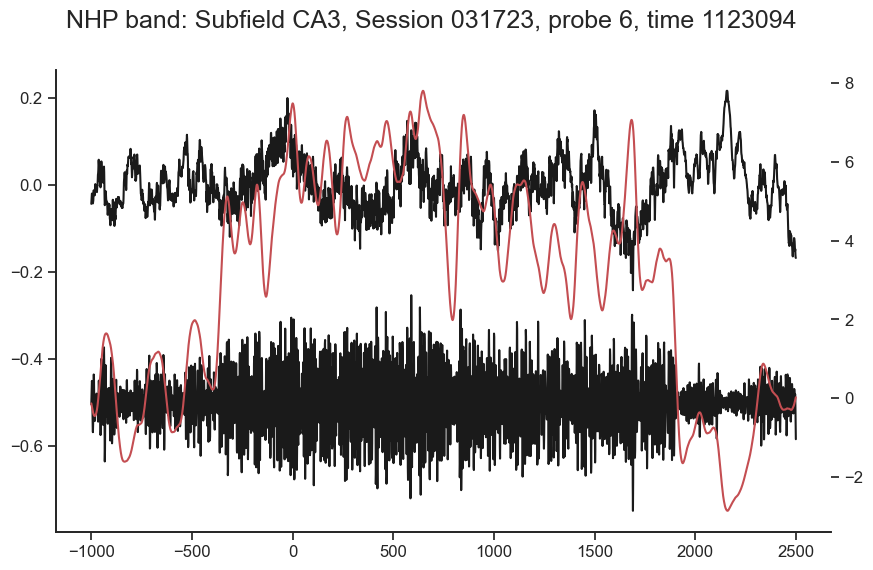

In [61]:
which = 'NHP band'
center = 1123094
window = [-1000,2500]
timestamps = np.arange(center+window[0],center+window[1])

plt.close('all')
fig, ax = plt.subplots(figsize=(10,6))

plt.plot(np.arange(window[0],window[1]),preprocessed[timestamps],'k-')
plt.plot(np.arange(window[0],window[1]),rippleband[timestamps]*5-0.5,'k-')
# plt.plot(np.arange(-1000,1000),smoothed[timestamps]*5-4,'k-')

ax2 = ax.twinx()

ax2.plot(np.arange(window[0],window[1]),zscored[timestamps],'r-')
# plt.vlines(peaks_comb[(peaks_comb>timestamps[0]) & (peaks_comb<timestamps[-1])]-center,zscored[timestamps].min(),zscored[timestamps].max())    
# plt.axvspan(ons_comb[idx]-center,offs_comb[idx]-center,color='magenta',alpha=0.1)

plt.suptitle('%s: Subfield %s, Session %s, probe %i, time %i' % (which,subfield,date,nprobe,center),fontsize=18)
plt.savefig('%s: Subfield %s, Session %s, probe %i, time %i' % (which,subfield,date,nprobe,center))


In [87]:
rippleband, smoothed, zscored, true_peaks, ons, offs = detect_ripple(preprocessed, noise, band)

6433
27753
35979
40446
43524
48338
51454
73165
82193
96327
104339
107659
110541
115740
116026
120006
120090
121684
124769
127687
129040
129904
130363
153002
158363
159030
162012
162120
162224
162311
162510
162620
162715
162864
162917
163094
163256
163439
163624
163798
163957
164114
164795
164956
165034
165244
165392
165575
165659
165822
165919
166029
166121
166244
166391
166703
168659
168764
168945
169108
169220
169327
169434
169517
169595
169672
169829
169914
170012
170105
170170
170316
170422
170539
170618
170729
170800
170876
171207
171429
171504
171626
171778
171852
171979
172063
172553
172744
172890
172966
173039
173194
173323
173404
173521
173674
173791
173894
174025
174148
174209
174270
174344
174447
174578
174698
174756
174825
174969
175074
175252
175378
175562
176165
176240
176355
176450
176640
176792
176960
177106
177384
177539
177844
178157
178357
178415
178625
178906
179036
179154
179300
179388
179481
179629
179847
179935
180338
180560
180794
182384
182581
182659
182749
183

ValueError: zero-size array to reduction operation minimum which has no identity

In [239]:
data = np.load("MI first step node 200.npy", allow_pickle=True).item()

# Now `data` is the dict you originally saved
MI         = data["MI"]
zscored_MI = data["zscored_MI"]
sparsity   = data["sparsity"]
Lambda     = data["Lambda"]
Lambda_i   = data["Lambda_i"]
null       = data["null"]
label      = data["label"]

criterion1 = MI > np.percentile(null, 95, axis=1)
criterion2 = Lambda > 1
criterion3 = MI > 0
sig = criterion1*criterion2*criterion3

# number of neurons per session
Num_neuron = np.insert(np.cumsum([80,94,88,73,88,60]),0,0)

ss = 0
idx = np.arange(Num_neuron[ss],Num_neuron[ss+1])
ses_MI = MI[idx,9]
ses_Lambda_i = np.argmax(Lambda_i[idx,9,:],axis=1)
ses_sig = sig[idx,9]
ses_sig.sum()

38

In [265]:
spatial = np.mean(num_spikes[:,ses_sig]>0,axis=1)
nonspatial = np.mean(num_spikes[:,~ses_sig]>0,axis=1)

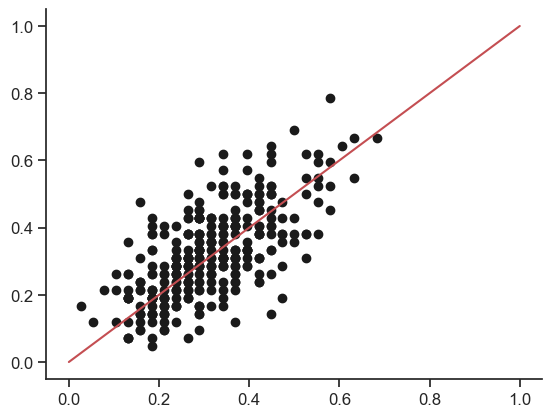

In [269]:
plt.close('all')
plt.scatter(spatial,nonspatial,color='k')
plt.plot([0,1],[0,1],'r-')

In [277]:
for ii in range(num_spikes.shape[0]):
    num_spikes[ii,:]

array([[False, False, False, ...,  True, False,  True],
       [ True,  True,  True, ...,  True,  True, False],
       [False,  True, False, ..., False,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [ True, False,  True, ..., False, False, False],
       [False,  True, False, ..., False, False, False]])

In [291]:
active_neuron

array([41., 35., 32., 10., 27., 24., 16., 38., 43., 31., 14.,  8., 29.,
       19., 25., 21., 29., 22., 27.,  8., 36., 13., 12., 22., 29., 16.,
       36., 26., 14., 20., 22., 20., 23., 26., 39., 32., 32., 24., 35.,
       22., 16., 28.,  8., 26., 22., 13., 21., 26., 28.,  9., 34., 16.,
       26., 15., 15., 29., 28., 27., 21., 25., 21., 24., 20., 29., 17.,
       15., 23., 23., 31., 23., 19., 29., 21., 13., 20., 16., 12., 16.,
       13., 15., 23., 13., 25., 23., 22., 22., 19., 25., 39., 18., 26.,
       21., 26., 30., 31., 29., 28., 29., 24., 26., 39., 13., 21., 16.,
       20., 18., 36., 33., 30., 13., 30., 35., 18., 23., 20., 15., 32.,
       37., 15., 35., 28., 34., 27., 31., 46., 20., 35., 16., 26., 15.,
       30., 26., 28., 23., 16., 23., 28., 24., 27., 25., 31., 34., 25.,
       35., 23., 30., 25., 25., 16., 15., 22., 41., 34., 15., 30., 37.,
       22., 13., 30., 19., 32., 26., 13., 19., 29., 39., 33., 26., 25.,
       34., 25., 24., 30., 25., 20., 18., 27., 33., 25., 16., 15

In [299]:
np.matmul(num_spikes,ses_sig.reshape(-1,1)).ravel()/active_neuron

array([0.90243902, 0.8       , 0.71875   , 0.5       , 0.7037037 ,
       0.33333333, 0.625     , 0.73684211, 0.46511628, 0.77419355,
       1.07142857, 0.625     , 0.55172414, 0.63157895, 1.        ,
       0.52380952, 0.86206897, 0.59090909, 0.59259259, 0.75      ,
       0.41666667, 0.76923077, 0.41666667, 0.5       , 0.44827586,
       0.5       , 0.77777778, 0.30769231, 0.71428571, 0.8       ,
       0.72727273, 0.6       , 0.69565217, 0.42307692, 0.84615385,
       0.8125    , 0.875     , 0.54166667, 0.6       , 1.04545455,
       0.4375    , 0.85714286, 0.375     , 0.88461538, 0.5       ,
       0.61538462, 0.57142857, 0.69230769, 0.71428571, 1.22222222,
       0.61764706, 0.4375    , 1.03846154, 0.46666667, 0.46666667,
       0.62068966, 0.64285714, 0.77777778, 0.33333333, 0.52      ,
       1.04761905, 0.70833333, 0.95      , 0.82758621, 0.88235294,
       0.73333333, 0.82608696, 1.2173913 , 0.41935484, 0.60869565,
       0.52631579, 0.86206897, 0.57142857, 1.        , 0.9    

In [130]:
diff = np.diff(preprocessed)
zscored_diff = (diff-diff.mean())/diff.std()
print(zscored_diff.max(),zscored_diff.min())

81.07839260212249 -28.097090413541917


(array([3.000000e+00, 1.400000e+01, 1.710000e+02, 1.355000e+03,
        1.084200e+04, 8.361500e+04, 6.536110e+05, 3.696267e+06,
        9.560190e+05, 1.640000e+02]),
 array([-16.20308559, -14.14323538, -12.08338517, -10.02353496,
         -7.96368476,  -5.90383455,  -3.84398434,  -1.78413413,
          0.27571608,   2.33556629,   4.3954165 ]),
 <BarContainer object of 10 artists>)

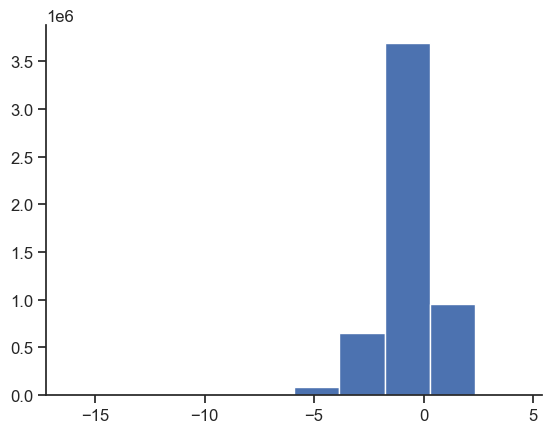

In [148]:
plt.close('all')
plt.hist(np.log(np.abs(zscored_diff))) #,bins=np.arange(20))

In [35]:
tic = time.time()
preprocessed, noise = preprocess_LFP(lfpData[:, 161], cutoff=15, fs=1000)
rippleband, smoothed, zscored, true_peaks, ons, offs = detect_ripple(preprocessed, noise, [80,180])
toc = time.time()
print(toc-tic)

35.267120122909546


In [97]:
_, idx = np.unique(ons,return_index=True)

In [99]:
_, idx2 = np.unique(offs,return_index=True)

In [126]:
# if there are consecutive multiple ripples, multiple peaks could be detected within the same event, combine them
_, idx = np.unique(ons,return_index=True)
ons_comb = ons[idx]
offs_comb = offs[idx]
peaks_comb = true_peaks[idx]

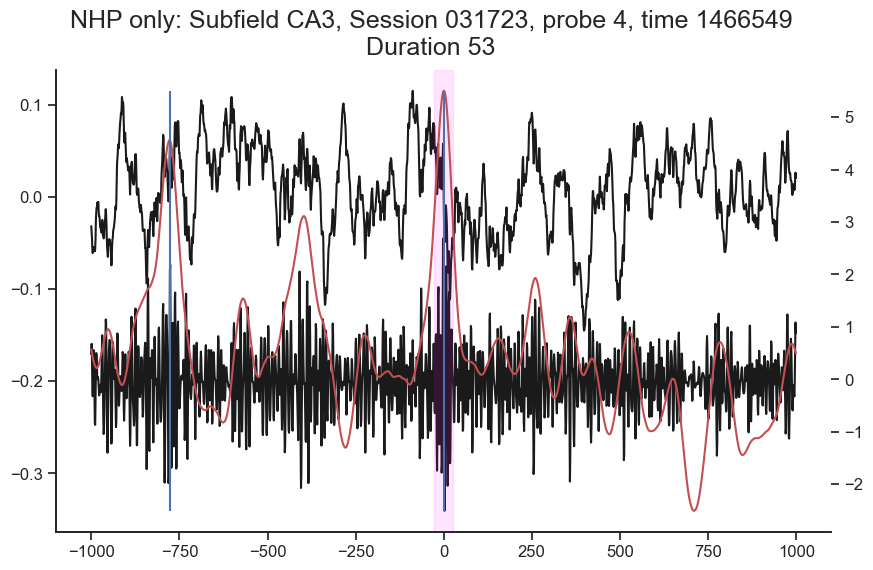

In [179]:
which = 'NHP only'
np.random.seed(42)

for idx in np.random.choice(len(peaks_comb), size=20, replace=False):

    center = peaks_comb[idx]
    timestamps = np.arange(center-1000,center+1000)
    
    plt.close('all')
    fig, ax = plt.subplots(figsize=(10,6))
    
    plt.plot(np.arange(-1000,1000),preprocessed[timestamps],'k-')
    plt.plot(np.arange(-1000,1000),rippleband[timestamps]*5-0.2,'k-')
    # plt.plot(np.arange(-1000,1000),smoothed[timestamps]*5-4,'k-')
    
    ax2 = ax.twinx()
    
    ax2.plot(np.arange(-1000,1000),zscored[timestamps],'r-')
    plt.vlines(peaks_comb[(peaks_comb>timestamps[0]) & (peaks_comb<timestamps[-1])]-center,zscored[timestamps].min(),zscored[timestamps].max())    
    plt.axvspan(ons_comb[idx]-center,offs_comb[idx]-center,color='magenta',alpha=0.1)
    
    plt.suptitle('%s: Subfield %s, Session %s, probe %i, time %i\nDuration %i' % (which,subfield,date,nprobe,center,offs[idx]-ons[idx]),fontsize=18)
    plt.savefig('%s: Subfield %s, Session %s, probe %i, time %i, Duration %i' % (which,subfield,date,nprobe,center,offs[idx]-ons[idx]))


In [185]:
# proportion of cells activated during individual ripple

dates = ['031723','032823','033123','032023','040423','040723']
Num_neuron = np.insert(np.cumsum([80,94,88,73,88,60]),0,0)

dates = ['031723']

# rat_ripple_FR = np.zeros(MI.shape[0])
# nhp_ripple_FR = np.zeros(MI.shape[0])

for ss, date in enumerate(dates):
    
    date_int = int(date[1:])
    probe = 4
    
    idx = np.arange(Num_neuron[ss],Num_neuron[ss+1])
    # ses_MI = MI[idx,9]
    # ses_Lambda_i = np.argmax(Lambda_i[idx,9,:],axis=1)
    # ses_sig = sig[idx,9]

    lfpFile = h5py.File('/Volumes/Extreme SSD/Teleworld/bart_I/raw/spikes/Bart_TeleWorld_v13_%s-spikes.mat' % date, 'r')
    spikesData = lfpFile['spikeTable']
    
    probe_info = pd.read_excel('/Users/lianghexin/Documents/Berkeley/Teleworld/Code/Bart Probe Info for Hexin.xlsx')
    ch_start, ch_end = probe_info.query("(date==@date_int) & (probe==@probe)")[['start_channel','end_channel']].values[0]
    
    nwbfile = import_behavior(date)
    unitNames = nwbfile.units.to_dataframe()
    subfield = unitNames.query("(probe==@probe)").subfield.unique()[0]
    unit_params = {"drift": 2, "min_fr": 1}
    unit_idx = np.where((unitNames.region == 'HPC') & (unitNames.group == "good") & (unitNames.drift <= unit_params["drift"]) & (unitNames.fr >= unit_params["min_fr"]))[0]

    
    nhp_ripple_spikes = []
    num_spikes = np.zeros((len(peaks_comb),len(unit_idx)))
    active_neuron = np.zeros(len(peaks_comb))
    
    for ii in range(len(peaks_comb)):
    
        timestamps = np.arange(ons_comb[ii],offs_comb[ii])
        ripple_spike = spikesData[timestamps,:][:,unit_idx]

        nhp_ripple_spikes.append(ripple_spikes)
        num_spikes[ii,:] = ripple_spike.sum(axis=0)
        active_neuron[ii] = np.sum(num_spikes[ii,:]>0)
        
#         nhp_ripple_FR.append(ripple_spike)

#     nhp_ripple_FR[idx] = nhp_ripple_FR_ss.mean(axis=1)


# ons_comb = ons[idx]
# offs_comb = offs[idx]
# peaks_comb = true_peaks[idx]


In [313]:
nhp_ripple_spikes = []
num_spikes = np.zeros((len(peaks_comb),len(unit_idx)))
active_neuron = np.zeros((len(peaks_comb),len(unit_idx)))
active_spatial = np.zeros((len(peaks_comb),len(unit_idx)))
active_nonspatial = np.zeros((len(peaks_comb),len(unit_idx)))

for ii in range(len(peaks_comb)):

    timestamps = np.arange(ons_comb[ii],offs_comb[ii])
    ripple_spike = spikesData[timestamps,:][:,unit_idx]

    nhp_ripple_spikes.append(ripple_spike)
    num_spikes[ii,:] = ripple_spike.sum(axis=0)
    active_neuron[ii] = num_spikes[ii,:]>0
    active_spatial[ii] = (num_spikes[ii,:]>0) & ses_sig
    active_nonspatial[ii] = (num_spikes[ii,:]>0) & (~ses_sig)

In [319]:
active_neuron.mean(axis=1)

array([0.5125, 0.4375, 0.4   , 0.125 , 0.3375, 0.3   , 0.2   , 0.475 ,
       0.5375, 0.3875, 0.175 , 0.1   , 0.3625, 0.2375, 0.3125, 0.2625,
       0.3625, 0.275 , 0.3375, 0.1   , 0.45  , 0.1625, 0.15  , 0.275 ,
       0.3625, 0.2   , 0.45  , 0.325 , 0.175 , 0.25  , 0.275 , 0.25  ,
       0.2875, 0.325 , 0.4875, 0.4   , 0.4   , 0.3   , 0.4375, 0.275 ,
       0.2   , 0.35  , 0.1   , 0.325 , 0.275 , 0.1625, 0.2625, 0.325 ,
       0.35  , 0.1125, 0.425 , 0.2   , 0.325 , 0.1875, 0.1875, 0.3625,
       0.35  , 0.3375, 0.2625, 0.3125, 0.2625, 0.3   , 0.25  , 0.3625,
       0.2125, 0.1875, 0.2875, 0.2875, 0.3875, 0.2875, 0.2375, 0.3625,
       0.2625, 0.1625, 0.25  , 0.2   , 0.15  , 0.2   , 0.1625, 0.1875,
       0.2875, 0.1625, 0.3125, 0.2875, 0.275 , 0.275 , 0.2375, 0.3125,
       0.4875, 0.225 , 0.325 , 0.2625, 0.325 , 0.375 , 0.3875, 0.3625,
       0.35  , 0.3625, 0.3   , 0.325 , 0.4875, 0.1625, 0.2625, 0.2   ,
       0.25  , 0.225 , 0.45  , 0.4125, 0.375 , 0.1625, 0.375 , 0.4375,
      

([<matplotlib.axis.XTick at 0x1670c66c0>,
 [Text(0.1, 0, '0.1'),
  Text(0.30000000000000004, 0, '0.3'),
  Text(0.5000000000000001, 0, '0.5'),
  Text(0.7000000000000002, 0, '0.7'),
  Text(0.9000000000000001, 0, '0.9')])

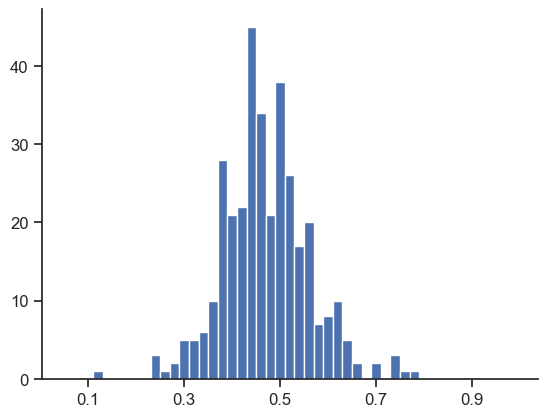

In [341]:
spatial_per_active = active_spatial.mean(axis=1)/active_neuron.mean(axis=1)
plt.close('all')
plt.hist(spatial_per_active,bins=np.arange(0.05,1,0.02))
plt.xticks(np.arange(0.1,1,0.2))

In [ ]:
# should combine ripples in the way that peak takes the maximum among multiple peaks

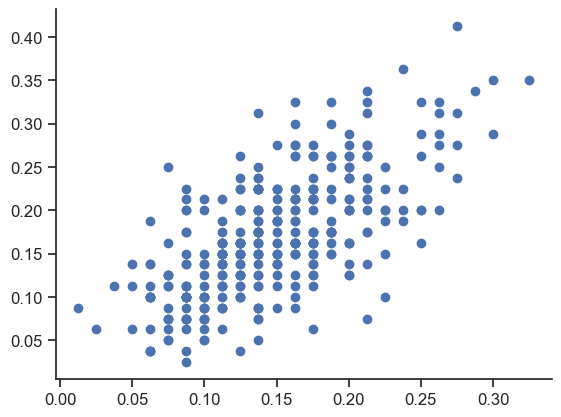

In [325]:
plt.close('all')
plt.scatter(active_spatial.mean(axis=1),active_nonspatial.mean(axis=1))

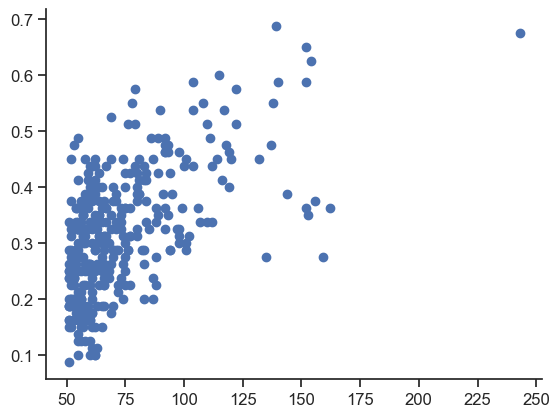

In [237]:
plt.close('all')
plt.scatter(offs_comb-ons_comb,active_neuron/len(unit_idx))

In [11]:
def find_match(A,B,offset=50):

    
    # Compare all pairs: shape (len(A), len(B))
    diff_matrix = np.abs(A[:, None] - B[None, :])

    rows,cols = np.where(diff_matrix<=50)
    matches = ((A[rows]+B[cols])/2).astype(int)
        
    # Check if each A has any B within ±tol
    A_has_match = (diff_matrix <= offset).any(axis=1)
    
    # Check if each B has any A within ±tol
    B_has_match = (diff_matrix <= offset).any(axis=0)
    
    A_only = A[~A_has_match].astype(int)
    B_only = B[~B_has_match].astype(int)

    return matches, A_only, B_only

In [13]:
sz1 = 18
sz2 = 24
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
matplotlib.rc('xtick', labelsize=sz1) 
matplotlib.rc('ytick', labelsize=sz1) 
matplotlib.rc('axes', labelsize=sz1)  
matplotlib.rc('axes', titlesize=sz1)  
matplotlib.rc('figure', titlesize=sz2)
matplotlib.rc('legend', fontsize=sz1) 
matplotlib.rc('legend', title_fontsize=sz1)
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

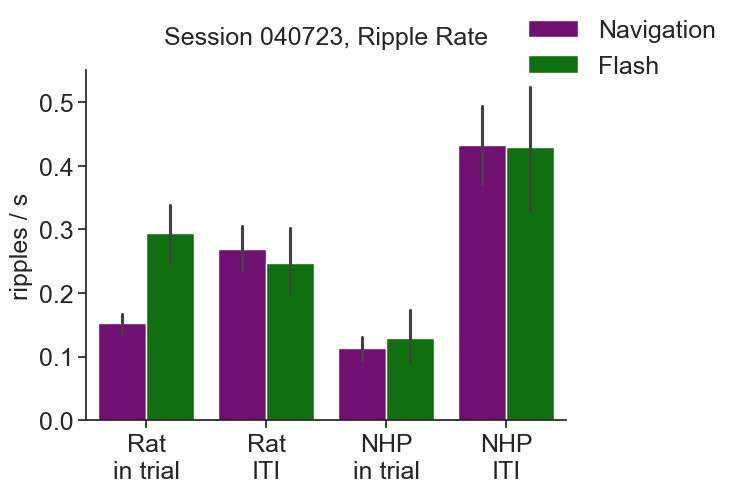

In [179]:
# aligned to behavior epochs, ripple rates

dates = ['031723','032023','032823','033123','040423','040723']
epoch = 'trials'


for date in dates:
    
    date_int = int(date[1:])
    probe = 4
    probe_info = pd.read_excel('/Users/lianghexin/Documents/Berkeley/Teleworld/Code/Bart Probe Info for Hexin.xlsx')
    ch_start, ch_end = probe_info.query("(date==@date_int) & (probe==@probe)")[['start_channel','end_channel']].values[0]
    
    rat_peaks = import_ripple(date, [150,250])[np.arange(ch_start-1, ch_end)]
    nhp_peaks = import_ripple(date, [80,180])[np.arange(ch_start-1, ch_end)]
    
    rat_peaks_all = np.unique(np.concatenate(rat_peaks))
    nhp_peaks_all = np.unique(np.concatenate(nhp_peaks))

    rat_peaks_merged = merge_close_neighbors(rat_peaks_all)
    nhp_peaks_merged = merge_close_neighbors(nhp_peaks_all)
    
    nwbfile = import_behavior(date)
    df = nwbfile.intervals[epoch].to_dataframe() #.query(beh_query)
    df = df.loc[:,df.columns[:-1]]
    
    starts = df.start_time.values
    stops = df.stop_time.values
    
    rat_within_trial_ripples = [[] for i in range(len(df))]
    nhp_within_trial_ripples = [[] for i in range(len(df))]
    rat_ITI_ripples = [[] for i in range(len(df)-1)]
    nhp_ITI_ripples = [[] for i in range(len(df)-1)]
    
    for tt in range(len(df)):

        rat_within_trial_ripples[tt] = rat_peaks_merged[(rat_peaks_merged>starts[tt]) & (rat_peaks_merged<stops[tt])]-starts[tt]
        nhp_within_trial_ripples[tt] = nhp_peaks_merged[(nhp_peaks_merged>starts[tt]) & (nhp_peaks_merged<stops[tt])]-starts[tt]

        if tt>0:
            rat_ITI_ripples[tt-1] = rat_peaks_merged[(rat_peaks_merged>stops[tt-1]) & (rat_peaks_merged<starts[tt])]-stops[tt-1]
            nhp_ITI_ripples[tt-1] = nhp_peaks_merged[(nhp_peaks_merged>stops[tt-1]) & (nhp_peaks_merged<starts[tt])]-stops[tt-1]

    rat_ITI_ripples =  rat_ITI_ripples + [np.array([])]
    nhp_ITI_ripples =  nhp_ITI_ripples + [np.array([])]
    
    df['rat_intrial'] = rat_within_trial_ripples
    df['nhp_intrial'] = nhp_within_trial_ripples
    df['rat_ITI'] = rat_ITI_ripples
    df['nhp_ITI'] = nhp_ITI_ripples
    df['trial_dur'] = df['stop_time']-df['start_time']
    df['ITI_dur'] = np.insert(df['start_time'].values[1:] - df['stop_time'].values[:-1],-1,np.nan)
    
    df['rat_intrial_rate'] = df.apply(lambda row:len(row['rat_intrial'])/row['trial_dur']*1000, axis=1)
    df['nhp_intrial_rate'] = df.apply(lambda row:len(row['nhp_intrial'])/row['trial_dur']*1000, axis=1)
    df['rat_ITI_rate'] = df.apply(lambda row:len(row['rat_ITI'])/row['ITI_dur']*1000, axis=1)
    df['nhp_ITI_rate'] = df.apply(lambda row:len(row['nhp_ITI'])/row['ITI_dur']*1000, axis=1)

    df_melted = df.melt(
        value_vars=['rat_intrial_rate', 'nhp_intrial_rate', 'rat_ITI_rate', 'nhp_ITI_rate'],
        id_vars = 'trialerror',
        var_name='Condition',
        value_name='Rate'
    )
    
    df_melted = df_melted.query("trialerror<2")
    
    plt.close('all')
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(data=df_melted,x='Condition',y='Rate',hue='trialerror',palette=['purple', 'green'],
                    order=['rat_intrial_rate', 'rat_ITI_rate', 'nhp_intrial_rate', 'nhp_ITI_rate'])
    
    plt.ylabel('ripples / s')
    plt.title('Session %s, Ripple Rate' % date,y=1.05)
    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(['Rat\nin trial', 'Rat\nITI', 'NHP\nin trial', 'NHP\nITI'],rotation=0)
    ax.set_xlabel('')
    
    ax.legend(title="", labels=["Navigation", "Flash"])
    handles, labels = ax.get_legend_handles_labels()
    bar_handles = handles[0:2]
    ax.legend(bar_handles, ["Navigation", "Flash"], title="",loc=(0.9,0.95),frameon=False)
    ax.set_position([0.15,0.15,0.6,0.7])

    plt.savefig('Session %s Ripple Rate, NHP vs rat, ITI vs in trial, nav vs flash' % date)

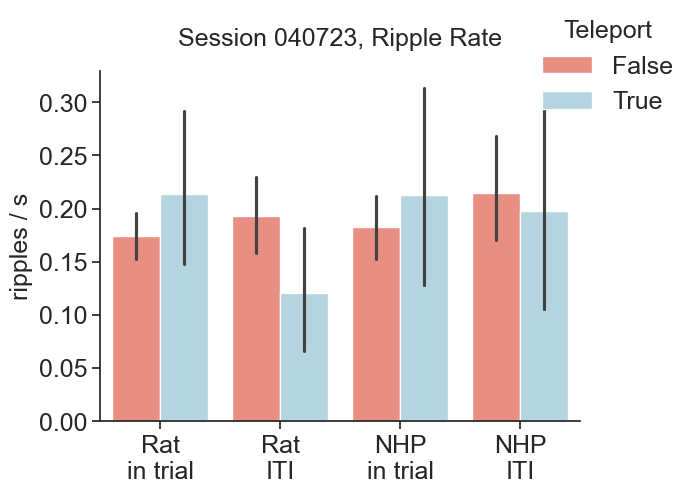

In [465]:
# aligned to behavior epochs, ripple rates

dates = ['031723','032023','032823','033123','040423','040723']
epoch = 'trials'

for date in dates:
    
    date_int = int(date[1:])
    probe = 4
    probe_info = pd.read_excel('/Users/lianghexin/Documents/Berkeley/Teleworld/Code/Bart Probe Info for Hexin.xlsx')
    ch_start, ch_end = probe_info.query("(date==@date_int) & (probe==@probe)")[['start_channel','end_channel']].values[0]
    
    rat_peaks = import_ripple(date, [150,250])[np.arange(ch_start-1, ch_end)]
    nhp_peaks = import_ripple(date, [80,180])[np.arange(ch_start-1, ch_end)]
    
    rat_peaks_all = np.unique(np.concatenate(rat_peaks))
    nhp_peaks_all = np.unique(np.concatenate(nhp_peaks))

    rat_peaks_merged = merge_close_neighbors(rat_peaks_all)
    nhp_peaks_merged = merge_close_neighbors(nhp_peaks_all)
    
    nwbfile = import_behavior('031723')
    df = nwbfile.intervals['trials'].to_dataframe().query('trialerror==0')
    choice_df = nwbfile.intervals['action_on'].to_dataframe().query('trialerror==0')
    choice_df = graph.append_use_tele(choice_df)
    df['use_tele'] = choice_df.drop_duplicates('trial').use_tele.values

    starts = df.start_time.values
    stops = df.stop_time.values
    
    rat_within_trial_ripples = [[] for i in range(len(df))]
    nhp_within_trial_ripples = [[] for i in range(len(df))]
    rat_ITI_ripples = [[] for i in range(len(df)-1)]
    nhp_ITI_ripples = [[] for i in range(len(df)-1)]
    
    for tt in range(len(df)):

        rat_within_trial_ripples[tt] = rat_peaks_merged[(rat_peaks_merged>starts[tt]) & (rat_peaks_merged<stops[tt])]-starts[tt]
        nhp_within_trial_ripples[tt] = nhp_peaks_merged[(nhp_peaks_merged>starts[tt]) & (nhp_peaks_merged<stops[tt])]-starts[tt]

        if tt>0:
            rat_ITI_ripples[tt-1] = rat_peaks_merged[(rat_peaks_merged>stops[tt-1]) & (rat_peaks_merged<starts[tt])]-stops[tt-1]
            nhp_ITI_ripples[tt-1] = nhp_peaks_merged[(nhp_peaks_merged>stops[tt-1]) & (nhp_peaks_merged<starts[tt])]-stops[tt-1]

    rat_ITI_ripples =  rat_ITI_ripples + [np.array([])]
    nhp_ITI_ripples =  nhp_ITI_ripples + [np.array([])]
    
    df['rat_intrial'] = rat_within_trial_ripples
    df['nhp_intrial'] = nhp_within_trial_ripples
    df['rat_ITI'] = rat_ITI_ripples
    df['nhp_ITI'] = nhp_ITI_ripples
    df['trial_dur'] = df['stop_time']-df['start_time']
    df['ITI_dur'] = np.insert(df['start_time'].values[1:] - df['stop_time'].values[:-1],-1,np.nan)
    
    df['rat_intrial_rate'] = df.apply(lambda row:len(row['rat_intrial'])/row['trial_dur']*1000, axis=1)
    df['nhp_intrial_rate'] = df.apply(lambda row:len(row['nhp_intrial'])/row['trial_dur']*1000, axis=1)
    df['rat_ITI_rate'] = df.apply(lambda row:len(row['rat_ITI'])/row['ITI_dur']*1000, axis=1)
    df['nhp_ITI_rate'] = df.apply(lambda row:len(row['nhp_ITI'])/row['ITI_dur']*1000, axis=1)

    df_melted = df.melt(
        value_vars=['rat_intrial_rate', 'nhp_intrial_rate', 'rat_ITI_rate', 'nhp_ITI_rate'],
        id_vars = 'use_tele',
        var_name='Condition',
        value_name='Rate'
    )
        
    plt.close('all')
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(data=df_melted,x='Condition',y='Rate',hue='use_tele',palette=['salmon', 'lightblue'],
                    order=['rat_intrial_rate', 'rat_ITI_rate', 'nhp_intrial_rate', 'nhp_ITI_rate'])
    
    plt.ylabel('ripples / s')
    plt.title('Session %s, Ripple Rate' % date,y=1.05)
    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(['Rat\nin trial', 'Rat\nITI', 'NHP\nin trial', 'NHP\nITI'],rotation=0)
    ax.set_xlabel('')

    ax.legend(title='Teleport',loc=(0.9,0.85),frameon=False)
    ax.set_position([0.15,0.15,0.6,0.7])

    plt.savefig('Session %s Ripple Rate, NHP vs rat, ITI vs in trial, teleport' % date)

In [ ]:
# should record ripple amplitude, visualize the largest ripples first

In [175]:
from matplotlib.colors import LinearSegmentedColormap
def interpolate_colors(color1, color2, num_colors):
    """
    Interpolates a list of colors between two given colors.

    Parameters:
    color1 (str or tuple): The starting color, can be a name or an RGB tuple.
    color2 (str or tuple): The ending color, can be a name or an RGB tuple.
    num_colors (int): The number of colors to generate between color1 and color2.

    Returns:
    list: A list of interpolated colors in RGBA format.
    """
    cmap = LinearSegmentedColormap.from_list('custom_cmap', [color1, color2], N=num_colors)
    colors = [cmap(i) for i in range(num_colors)]
    return colors
    
c1 = "#fc0303" # red
c2 = "#d000ff" # purple
c3 = "#0800ff" # blue
c4 = "#03b6fc" # cyan

caxis_1 = interpolate_colors(c1, c2, 4)
caxis_2 = interpolate_colors(c3, c4, 4)
cmap_2d = np.array([interpolate_colors(caxis_1[i], caxis_2[i], 4) for i in range(4)])

In [113]:
beh = import_behavior('032023','trials')
trial = 9
timestamps = np.arange(int(beh.start_time[trial])-1500,int(beh.start_time[trial])+1000)
ripple_exists = np.where((all_peaks[100]>timestamps[0]) & (all_peaks[100]<timestamps[-1]))[0]
print(ripple_exists)


In [157]:
data = np.load("MI first step node 200.npy", allow_pickle=True).item()

# Now `data` is the dict you originally saved
MI         = data["MI"]
zscored_MI = data["zscored_MI"]
sparsity   = data["sparsity"]
Lambda     = data["Lambda"]
Lambda_i   = data["Lambda_i"]
null       = data["null"]
label      = data["label"]

criterion1 = MI > np.percentile(null, 95, axis=1)
criterion2 = Lambda > 1
criterion3 = MI > 0
sig = criterion1*criterion2*criterion3

# number of neurons per session
Num_neuron = np.insert(np.cumsum([80,94,88,73,88,60]),0,0)

ss = 0
idx = np.arange(Num_neuron[ss],Num_neuron[ss+1])
ses_MI = MI[idx,9]
ses_Lambda_i = np.argmax(Lambda_i[idx,9,:],axis=1)
ses_sig = sig[idx,9]
ses_sig.sum()

In [565]:
dates = ['031723','032823','033123','032023','040423','040723']

dates = ['031723']

rat_ripple_FR = np.zeros(MI.shape[0])
nhp_ripple_FR = np.zeros(MI.shape[0])

for ss, date in enumerate(dates):
    
    date_int = int(date[1:])
    probe = 4
    
    idx = np.arange(Num_neuron[ss],Num_neuron[ss+1])
    ses_MI = MI[idx,9]
    ses_Lambda_i = np.argmax(Lambda_i[idx,9,:],axis=1)
    ses_sig = sig[idx,9]

    lfpFile = h5py.File('/Volumes/Extreme SSD/Teleworld/bart_I/raw/spikes/Bart_TeleWorld_v13_%s-spikes.mat' % date, 'r')
    spikesData = lfpFile['spikeTable']
    
    probe_info = pd.read_excel('/Users/lianghexin/Documents/Berkeley/Teleworld/Code/Bart Probe Info for Hexin.xlsx')
    ch_start, ch_end = probe_info.query("(date==@date_int) & (probe==@probe)")[['start_channel','end_channel']].values[0]
    
    nwbfile = import_behavior(date)
    unitNames = nwbfile.units.to_dataframe()
    subfield = unitNames.query("(probe==@probe)").subfield.unique()[0]
    unit_params = {"drift": 2, "min_fr": 1}
    unit_idx = np.where((unitNames.region == 'HPC') & (unitNames.group == "good") & (unitNames.drift <= unit_params["drift"]) & (unitNames.fr >= unit_params["min_fr"]))[0]

    rat_peaks = import_ripple(date, [150,250])[np.arange(ch_start-1, ch_end)]
    nhp_peaks = import_ripple(date, [80,180])[np.arange(ch_start-1, ch_end)]
    
    rat_peaks_all = np.unique(np.concatenate(rat_peaks))
    nhp_peaks_all = np.unique(np.concatenate(nhp_peaks))
    
    rat_peaks_merged = merge_close_neighbors(rat_peaks_all).astype(int)
    nhp_peaks_merged = merge_close_neighbors(nhp_peaks_all).astype(int)

    
    nhp_ripple_FR_ss = np.zeros((len(unit_idx),len(nhp_peaks_merged)))
    for ii, pp in enumerate(nhp_peaks_merged):
    
        timestamps = np.arange(pp-25,pp+25)
        ripple_spike = spikesData[timestamps,:][:,unit_idx]
        nhp_ripple_FR_ss[:,ii]=ripple_spike.mean(axis=0)*1000

    nhp_ripple_FR[idx] = nhp_ripple_FR_ss.mean(axis=1)
    
    rat_ripple_FR_ss = np.zeros((len(unit_idx),len(rat_peaks_merged)))
    for ii, pp in enumerate(rat_peaks_merged):
    
        timestamps = np.arange(pp-50,pp+50)
        ripple_spike = spikesData[timestamps,:][:,unit_idx]
        rat_ripple_FR_ss[:,ii]=ripple_spike.mean(axis=0)*1000

    rat_ripple_FR[idx] = rat_ripple_FR_ss.mean(axis=1)

In [635]:
ripple_spike.shape

(100, 60)

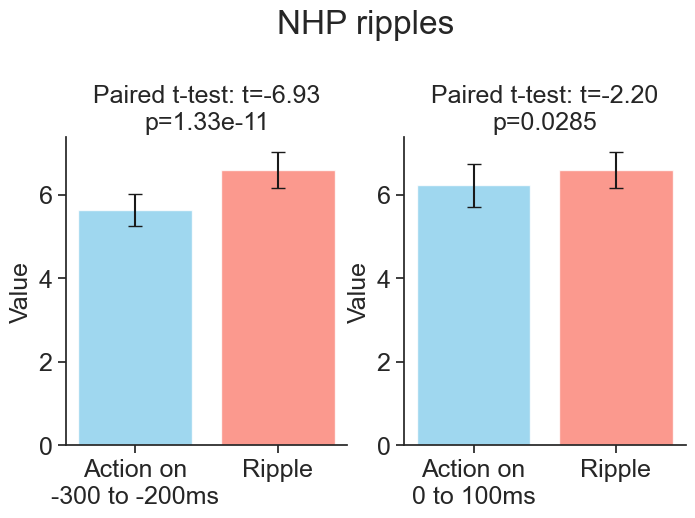

In [615]:
plt.close('all')
fig,ax = plt.subplots(1,2,figsize=(8,4))

ts = 3

tstat, pval = ttest_rel(Lambda[:,ts], nhp_ripple_FR)

# your two paired samples
x1 = Lambda[:, ts]
x2 = nhp_ripple_FR

# means and SEMs
means = [np.mean(x1), np.mean(x2)]
sems = [np.std(x1)/np.sqrt(len(x1)), np.std(x2)/np.sqrt(len(x2))]

# barplot
bars = ax[0].bar([0,1], means, yerr=sems, capsize=5, color=["skyblue","salmon"], alpha=0.8)

# beautify
ax[0].set_xticks([0,1])
ax[0].set_xticklabels(["Action on\n-300 to -200ms", "Ripple"])
ax[0].set_ylabel("Value")
ax[0].set_title(f"Paired t-test: t={tstat:.2f}\np={pval:.3g}")


ts = 9

tstat, pval = ttest_rel(Lambda[:,ts], nhp_ripple_FR)

# your two paired samples
x1 = Lambda[:, ts]
x2 = nhp_ripple_FR

# means and SEMs
means = [np.mean(x1), np.mean(x2)]
sems = [np.std(x1)/np.sqrt(len(x1)), np.std(x2)/np.sqrt(len(x2))]

# barplot
bars = ax[1].bar([0,1], means, yerr=sems, capsize=5, color=["skyblue","salmon"], alpha=0.8)

# beautify
ax[1].set_xticks([0,1])
ax[1].set_xticklabels(["Action on\n0 to 100ms", "Ripple"])
ax[1].set_ylabel("Value")
ax[1].set_title(f"Paired t-test: t={tstat:.2f}\np={pval:.3g}")

plt.suptitle('NHP ripples',y=1.2)
plt.savefig('NHP rippels FR')

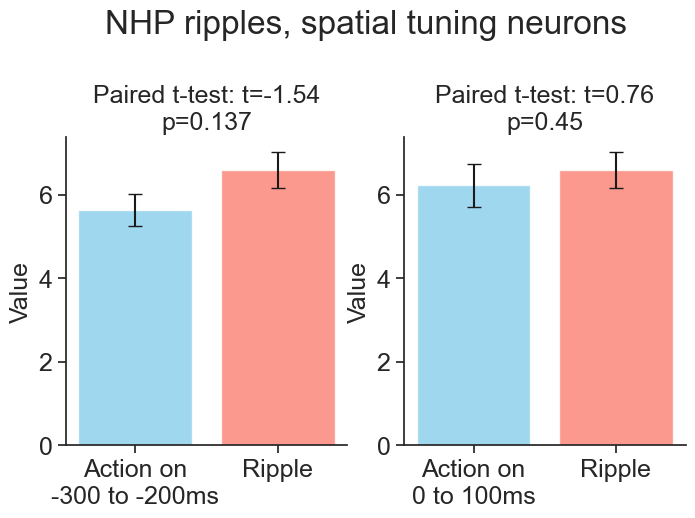

In [625]:
plt.close('all')
fig,ax = plt.subplots(1,2,figsize=(8,4))

ts = 3

tstat, pval = ttest_rel(Lambda[sig[:,ts],ts], nhp_ripple_FR[sig[:,ts]])

# your two paired samples
x1 = Lambda[:, ts]
x2 = nhp_ripple_FR

# means and SEMs
means = [np.mean(x1), np.mean(x2)]
sems = [np.std(x1)/np.sqrt(len(x1)), np.std(x2)/np.sqrt(len(x2))]

# barplot
bars = ax[0].bar([0,1], means, yerr=sems, capsize=5, color=["skyblue","salmon"], alpha=0.8)

# beautify
ax[0].set_xticks([0,1])
ax[0].set_xticklabels(["Action on\n-300 to -200ms", "Ripple"])
ax[0].set_ylabel("Value")
ax[0].set_title(f"Paired t-test: t={tstat:.2f}\np={pval:.3g}")


ts = 9

tstat, pval = ttest_rel(Lambda[sig[:,ts],ts], nhp_ripple_FR[sig[:,ts]])

# your two paired samples
x1 = Lambda[:, ts]
x2 = nhp_ripple_FR

# means and SEMs
means = [np.mean(x1), np.mean(x2)]
sems = [np.std(x1)/np.sqrt(len(x1)), np.std(x2)/np.sqrt(len(x2))]

# barplot
bars = ax[1].bar([0,1], means, yerr=sems, capsize=5, color=["skyblue","salmon"], alpha=0.8)

# beautify
ax[1].set_xticks([0,1])
ax[1].set_xticklabels(["Action on\n0 to 100ms", "Ripple"])
ax[1].set_ylabel("Value")
ax[1].set_title(f"Paired t-test: t={tstat:.2f}\np={pval:.3g}")

plt.suptitle('NHP ripples, spatial tuning neurons',y=1.2)
plt.savefig('NHP rippels FR, spatial tuning neurons')

(0.0, 5.0)

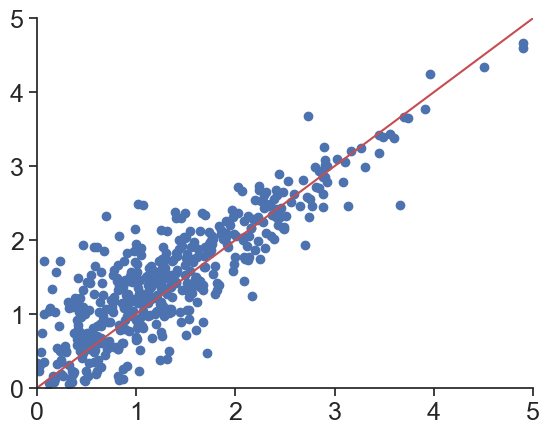

In [587]:
plt.close('all')
plt.scatter(np.log(Lambda[:,9]),np.log(nhp_ripple_FR))
plt.plot([0,15],[0,15],'r-')
plt.xlim(0,5)
plt.ylim(0,5)

In [537]:
from scipy.stats import ttest_rel

In [273]:
colors = sns.color_palette('Set1',16)

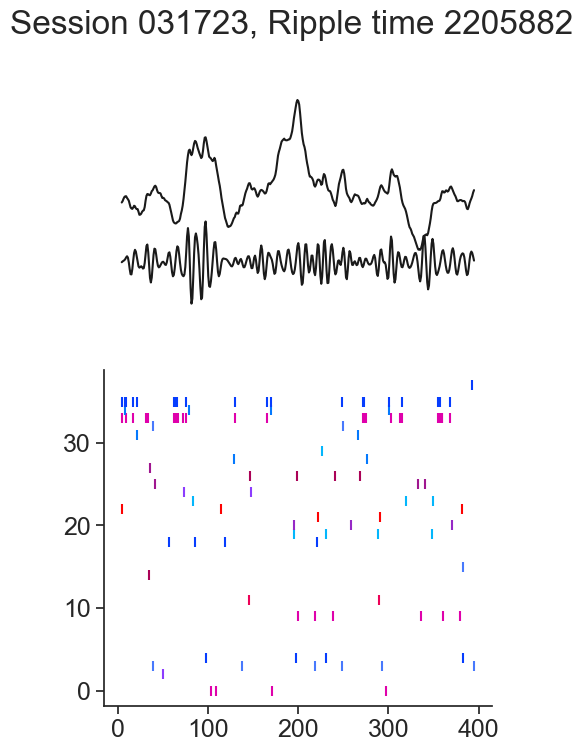

In [335]:
for pp in np.random.choice(nhp_peaks_merged, size=10, replace=False):

    timestamps = np.arange(pp-200,pp+200)
    ripple_spike = spikesData[timestamps,:][:,unit_idx]
    lfps,nhp_ripple_band,nhp_ripple_time = get_signal_per_probe(probe_info,date,probe,timestamps,[80,180])
    
    plt.close('all')
    fig, ax = plt.subplots(2,1,figsize=(5,8),height_ratios=[0.4,0.6])
    ii = -1
    ax[0].plot(lfps[:,ii],'k-')
    ax[0].plot(nhp_ripple_band[:,ii]*5-0.25,'k-')
    ax[0].axis('off')
    
    for ii, nn in enumerate(np.where(ses_sig)[0]):
        nn_spikes = np.where(ripple_spike[:,nn])[0]
        if ses_sig[nn]:
            ax[1].scatter(nn_spikes,ii*np.ones(len(nn_spikes)),50,marker='|',color=cmap_2d[np.divmod(ses_Lambda_i[nn],4)])
        # else:
        #     plt.scatter(nn_spikes,nn*np.ones(len(nn_spikes)),50,marker='|',color='gray')
    
    plt.suptitle('Session %s, Ripple time %i' % (date,pp))
    plt.savefig('Session %s, Ripple time %i.jpg' % (date,pp))

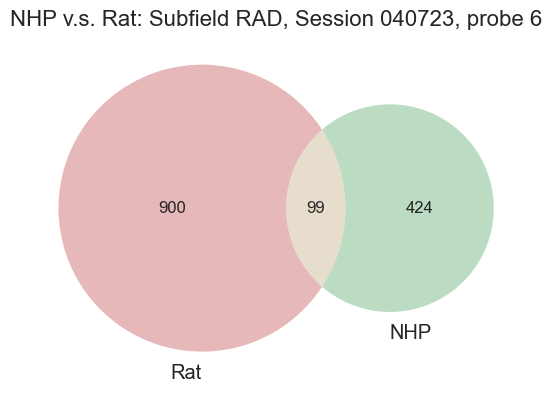

In [29]:
dates = ['031723','032023','032823','033123','040423','040723']
dates = ['031723','032823','033123','040423','040723']

for date in dates:
    
    date_int = int(date[1:])
    probe = 6
    probe_info = pd.read_excel('/Users/lianghexin/Documents/Berkeley/Teleworld/Code/Bart Probe Info for Hexin.xlsx')
    ch_start, ch_end = probe_info.query("(date==@date_int) & (probe==@probe)")[['start_channel','end_channel']].values[0]

    nwbfile = import_behavior(date)
    unitNames = nwbfile.units.to_dataframe()
    subfield = unitNames.query("(probe==@probe)").subfield.unique()[0]
    
    rat_peaks = import_ripple(date, [150,250])[np.arange(ch_start-1, ch_end)]
    nhp_peaks = import_ripple(date, [80,180])[np.arange(ch_start-1, ch_end)]
    
    rat_peaks_all = np.unique(np.concatenate(rat_peaks))
    nhp_peaks_all = np.unique(np.concatenate(nhp_peaks))
    
    rat_peaks_merged = merge_close_neighbors(rat_peaks_all)
    nhp_peaks_merged = merge_close_neighbors(nhp_peaks_all)
    
    matches, rat_only, nhp_only = find_match(rat_peaks_merged,nhp_peaks_merged)
    
    plt.close('all')
    venn2(subsets=(rat_only.shape[0], nhp_only.shape[0], matches.shape[0]), set_labels=('Rat','NHP'))
    plt.title('NHP v.s. Rat: Subfield %s, Session %s, probe %i' % (subfield,date,probe),fontsize=16)
    plt.savefig('Venn nhp vs rat, Subfield %s, Session %s, probe %i' % (subfield,date,probe))

In [329]:
matches, rat_only, nhp_only = find_match(rat_peaks_merged,nhp_peaks_merged)

In [493]:
rat_ripple_time

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

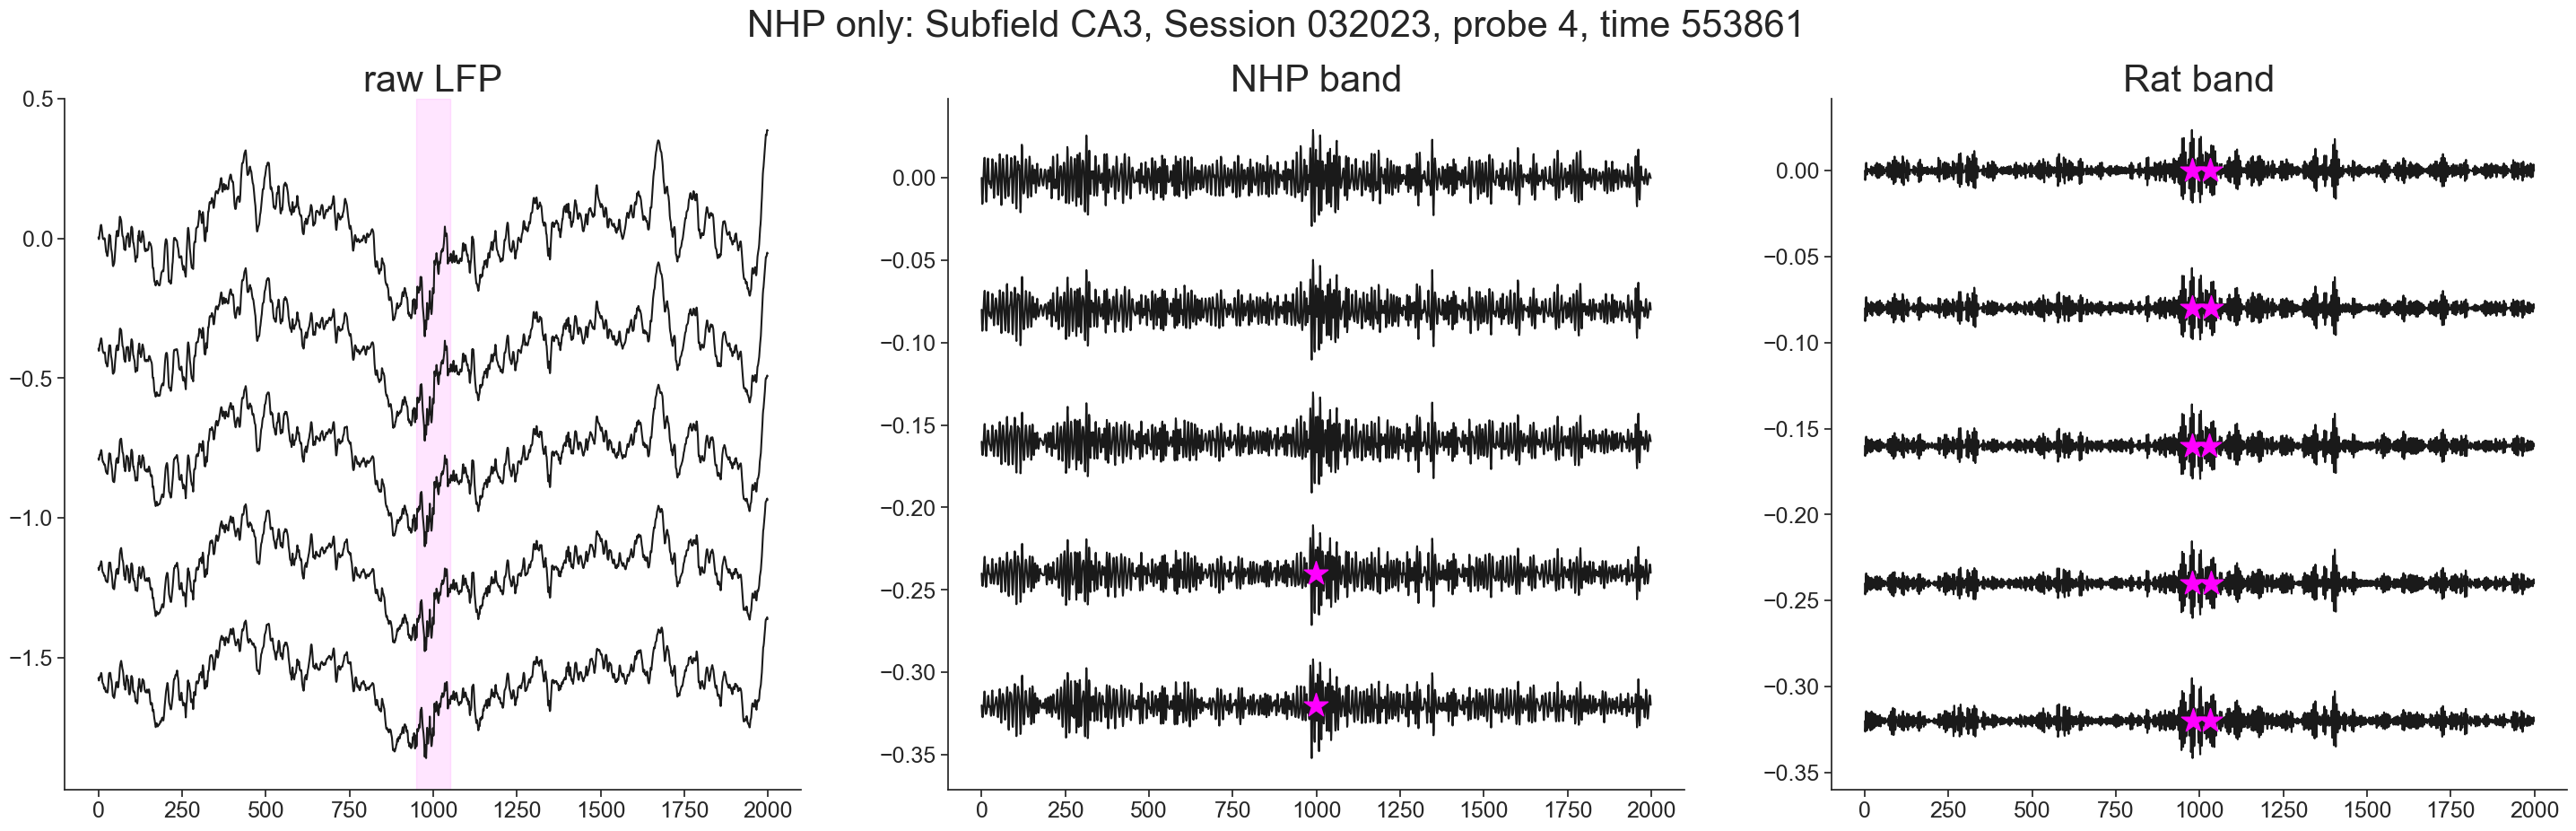

In [499]:
which = 'NHP only'

# for center in np.random.choice(nhp_only, size=10, replace=False):
center = 553861
date = '032023'
probe = 4

timestamps = np.arange(center-1000,center+1000)
lfps,rat_ripple_band,rat_ripple_time = get_signal_per_probe(probe_info,date,probe,timestamps,[150,250])
lfps,nhp_ripple_band,nhp_ripple_time = get_signal_per_probe(probe_info,date,probe,timestamps,[80,180])

plt.close('all')
fig, ax = plt.subplots(1,3,figsize=(36,10))

for ii in range(5):
    
    ax[0].plot(lfps[:,ii]-0.4*ii,'k-')
    ax[1].plot(nhp_ripple_band[:,ii]-0.08*ii,'k-')
    ax[2].plot(rat_ripple_band[:,ii]-0.08*ii,'k-')
    
    cols = np.where(nhp_ripple_time[:,ii])[0]
    for jj, col in enumerate(cols):
        ax[1].scatter(col,-0.08*ii,marker='*',s=400,color='magenta',zorder=2)

    cols = np.where(rat_ripple_time[:,ii])[0]
    for jj, col in enumerate(cols):
        ax[2].scatter(col,-0.08*ii,marker='*',s=400,color='magenta',zorder=2)

ax[0].axvspan(950,1050,color='magenta',alpha=0.1)
ax[0].set_title('raw LFP',fontsize=30)
ax[1].set_title('NHP band',fontsize=30)
ax[2].set_title('Rat band',fontsize=30)

plt.suptitle('%s: Subfield %s, Session %s, probe %i, time %i' % (which,subfield,date,probe,center),fontsize=30)
plt.savefig('%s, Subfield %s, Session %s, probe %i, time %i' % (which,subfield, date,probe,center))

Text(0.5, 1.0, 'Rat band')

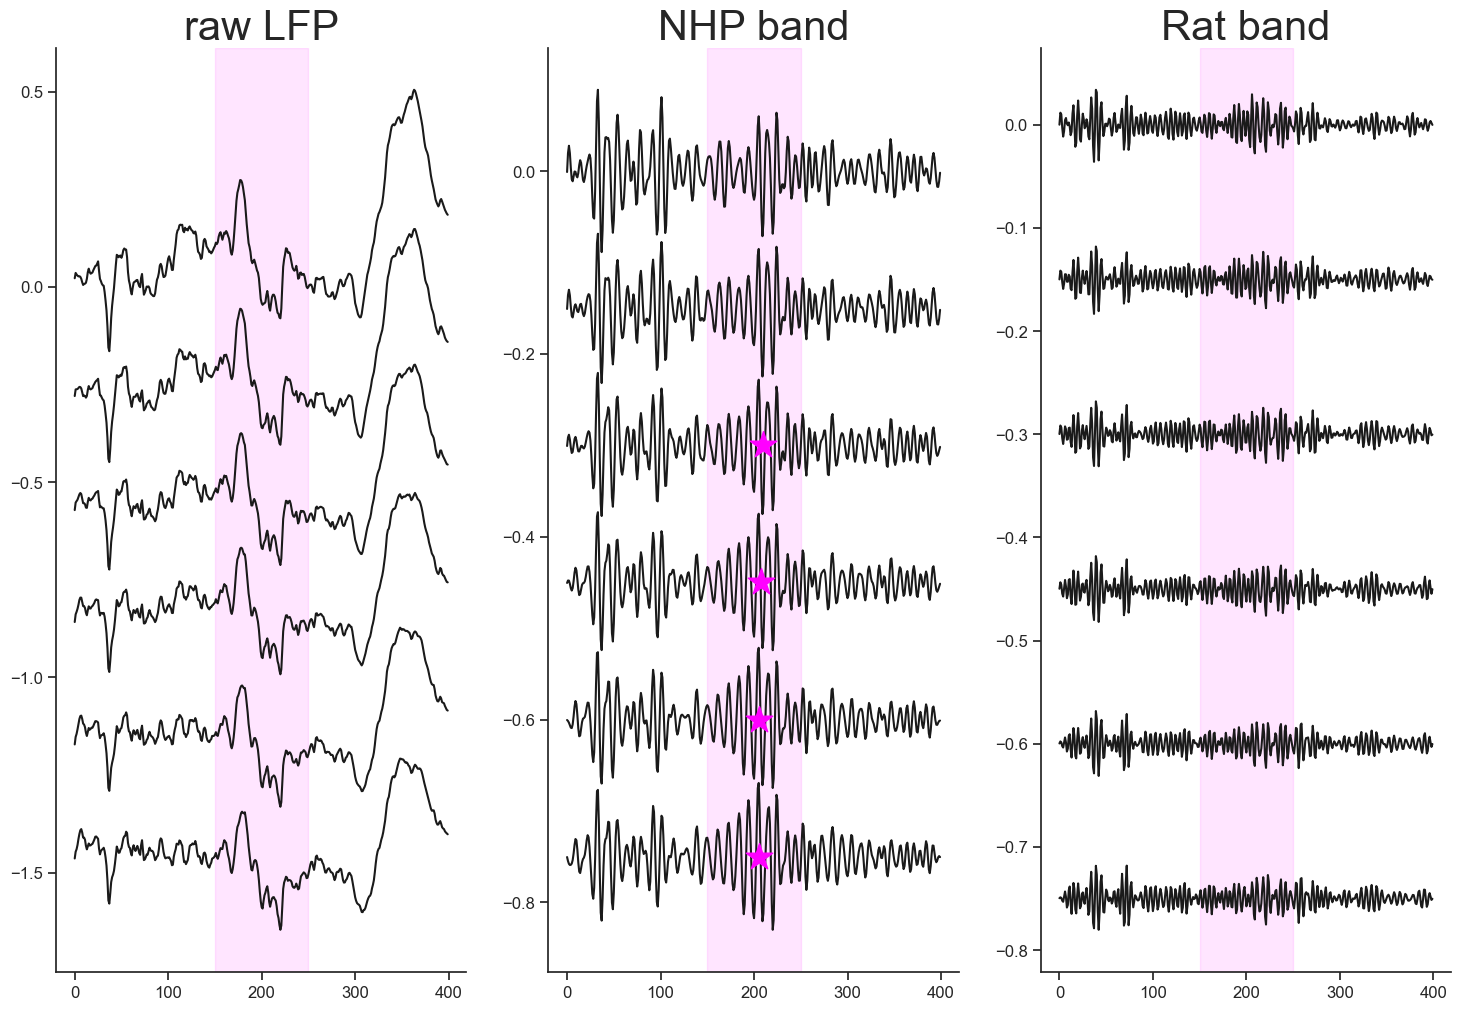

In [203]:
center = 1729071

timestamps = np.arange(center-200,center+200)
lfps,rat_ripple_band,rat_ripple_time = get_signal_per_probe(probe_info,'032023',4,timestamps,[150,250])
lfps,nhp_ripple_band,nhp_ripple_time = get_signal_per_probe(probe_info,'032023',4,timestamps,[80,180])

plt.close('all')
fig, ax = plt.subplots(1,3,figsize=(18,12))

for ii in range(6):
    
    ax[0].plot(lfps[:,ii]-0.3*ii,'k-')
    ax[1].plot(nhp_ripple_band[:,ii]*2.5-0.15*ii,'k-')
    ax[2].plot(rat_ripple_band[:,ii]*2.5-0.15*ii,'k-')
    
    cols = np.where(nhp_ripple_time[:,ii])[0]
    for jj, col in enumerate(cols):
        ax[1].scatter(col,-0.15*ii,marker='*',s=400,color='magenta',zorder=2)

    cols = np.where(rat_ripple_time[:,ii])[0]
    for jj, col in enumerate(cols):
        ax[2].scatter(col,-0.15*ii,marker='*',s=400,color='magenta',zorder=2)

ax[0].axvspan(150,250,color='magenta',alpha=0.1)
ax[1].axvspan(150,250,color='magenta',alpha=0.1)
ax[2].axvspan(150,250,color='magenta',alpha=0.1)

ax[0].set_title('raw LFP',fontsize=30)
ax[1].set_title('NHP band',fontsize=30)
ax[2].set_title('Rat band',fontsize=30)

In [57]:
def get_signal_per_probe(probe_info,date,probe,timestamps,band):

# this retrieves signal from all channels in one probe at a certain timestamp/window

    _, lfpData = import_LFP(date)
    all_peaks = import_ripple(date, band)
    
    int_date = int(date[1:])
    ch_start, ch_end = probe_info.query("(date==@int_date) & (probe==@probe)")[['start_channel','end_channel']].values[0]

    lfps = lfpData[timestamps,:][:,np.arange(ch_start-1, ch_end)]
    rippleband = np.zeros(lfps.shape)
    rippletime = np.zeros(lfps.shape)

    sos = butter(5, band, btype='bandpass', output='sos', fs=1000)

    for ii, channel in enumerate(range(ch_start-1, ch_end)):

        peaks = all_peaks[channel]
        rel_onset = (peaks[(peaks> timestamps[0]) & (peaks<timestamps[-1])]-timestamps[0]).astype(int)
        
        if len(rel_onset)>0:
            rippletime[rel_onset,ii] = 1
    
        preprocessed, _ = preprocess_LFP(lfps[:,ii])
        rippleband[:,ii] = sosfiltfilt(sos, preprocessed)
    

    return lfps,rippleband,rippletime


In [ ]:
### get ripple from specific probe

    timestamps, lfpData = import_LFP(date)
    
    allprobes = pd.read_excel('/Users/lianghexin/Documents/Berkeley/Teleworld/Code/Bart Probe Info for Hexin.xlsx')
    date_int = int(date[1:])  # removes the first char and converts to int
    probe_info = allprobes.query('date == @date_int')
    region_peaks = []
    
    data = np.load('/Users/lianghexin/Documents/Berkeley/Teleworld/Code/ripple band 80 180/session ripples %s 80 to 180.npz' % date, allow_pickle=True)    
    all_peaks, _ = data['peaks'], data['durs']

    for pp in range(len(probe_info)):
        
        start_ch = probe_info.iloc[pp]['start_channel']
        end_ch = probe_info.iloc[pp]['end_channel']   
        region_peaks.append(all_peaks[start_ch:end_ch+1])

    region_peaks = np.concatenate(region_peaks)

In [151]:
all_peaks[128]

array([  33405,   54373,   54436,   56882,   64706,  100643,  107212,
        112308,  120448,  134307,  137781,  153084,  165867,  237377,
        275101,  275153,  294695,  297054,  307734,  308977,  374507,
        410012,  410445,  439856,  501280,  505887,  597022,  661306,
        724034,  725466,  728807,  738816,  780340,  781522,  844142,
        923410,  968347, 1041381, 1060435, 1132878, 1145906, 1198536,
       1206716, 1211381, 1211432, 1233926, 1267617, 1482891, 1609467,
       1611280, 1611331, 1644049, 1647977, 1667504, 1686805, 1716014,
       1742178, 1760661, 1825745, 1946559, 1950753, 1963838, 1963890,
       1974943, 2094559, 2113407, 2134320, 2143411, 2158338, 2174596,
       2179523, 2186125, 2294742, 2308368, 2392733, 2392789, 2569822,
       2632391, 2670929, 2681254, 2684861, 2693812, 2714945, 2796628,
       2801884, 2844138, 2865610, 2888296, 2894750, 2916966, 2974083,
       3053024, 3070583, 3106056, 3145863, 3158348, 3265256, 3279311,
       3309178, 3347

In [ ]:
def get_signal_per_channel()

"""this retrieves signal from one channels across multiple timestamps/windows
"""

In [763]:
def get_signal(all_peaks, date, channel, time=[], aligned = 0, epoch = [], window = 1000):

    lfp = lfpData[time,channel]
    ripple_time = peaks[(peaks> time[0]) & (peaks<time[-1])]-time[0]

    return lfp, ripple_time

In [763]:
def get_signal(all_peaks, date, channel, time=[], aligned = 0, epoch = [], window = 1000):
    
    timestamps, lfpData = import_LFP(date)
    peaks = all_peaks[channel]

    if aligned:

        nwbfile = import_behavior(date)
        df = nwbfile.intervals[epoch].to_dataframe() #.query('trialerror==1')
        df = df.loc[:,df.columns[:-1]]
        
        lfp = np.zeros((len(df),np.diff(window)[0]))
        ripple_time = np.zeros((len(df),np.diff(window)[0]))
        starts = df.start_time.values
        
        for tt in range(len(df)):

            start = int(starts[tt]-1000)
            end = int(starts[tt]+1000)

            lfp[tt,:] = lfpData[start:end,channel]
            rel_onset = (peaks[(peaks> start) & (peaks<end)]-start).astype(int)
        
            if len(rel_onset)>0:
                ripple_time[tt,rel_onset] = 1
                
    else:

        if len(time)>0:
            lfp = lfpData[time,channel]
            ripple_time = peaks[(peaks> time[0]) & (peaks<time[-1])]-time[0]
        else:
            lfp = lfpData[:,channel]
            ripple_time = peaks
    
    return lfp, ripple_time

In [765]:
date = '032023'
band = [150,250]
all_peaks = import_ripple(date, band)
channel = 120
lfp, ripple_time = get_signal(all_peaks, date, channel, time=[], aligned = 1, epoch = 'trials', window = [-1000,1000])


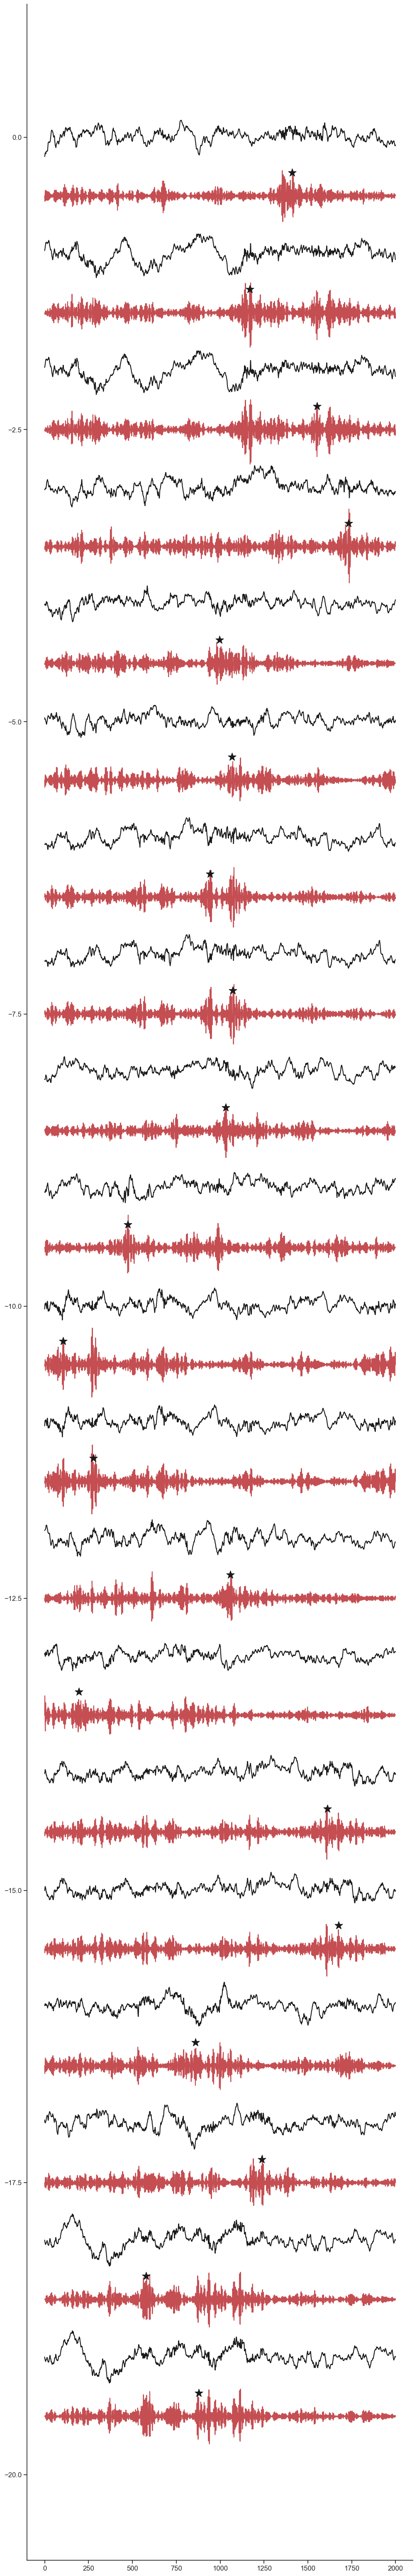

In [440]:
date = '032023'
band = [150,250]
all_peaks = import_ripple(date, band)
channel = 120
lfp, ripple_time = get_signal(all_peaks, date, channel, time=[], aligned = 1, epoch = 'trials', window = [-1000,1000])

rippleband = np.zeros(lfp.shape)
sos = butter(5, band, btype='bandpass', output='sos', fs=1000)

for ii in range(lfp.shape[0]):
    preprocessed, _ = preprocess_LFP(lfp[ii,:])
    rippleband[ii,:] = sosfiltfilt(sos, preprocessed)

rows,cols = np.where(ripple_time)

idx = np.arange(20,40)

plt.close('all')
plt.figure(figsize=(12,4*20))

for ii, (row, col) in enumerate(zip(rows[idx],cols[idx])):
    
    plt.plot(lfp[row,:]-ii,'k-')
    plt.plot(rippleband[row,:]*10-ii-0.5,'r-')
    plt.scatter(col,-ii-0.3,marker='*',s=200,color='k',zorder=2)

plt.savefig('Session %s, band %i to %i, channel %i, ripple example' % (date,band[0],band[1],channel))

In [513]:
date = '032023'
band = [80,180]
channel = 120

all_peaks = import_ripple(date, band)
lfp = np.zeros((all_peaks[channel].shape[0],400))
rippleband = np.zeros((all_peaks[channel].shape[0],400))
sos = butter(5, band, btype='bandpass', output='sos', fs=1000)

for ii, peak in enumerate(all_peaks[channel]):
    
    lfp[ii,:], _ = get_signal(all_peaks, date, channel, time=np.arange(peak-200,peak+200), aligned = 0)
    preprocessed, _ = preprocess_LFP(lfp[ii,:])
    rippleband[ii,:] = sosfiltfilt(sos, preprocessed)
    

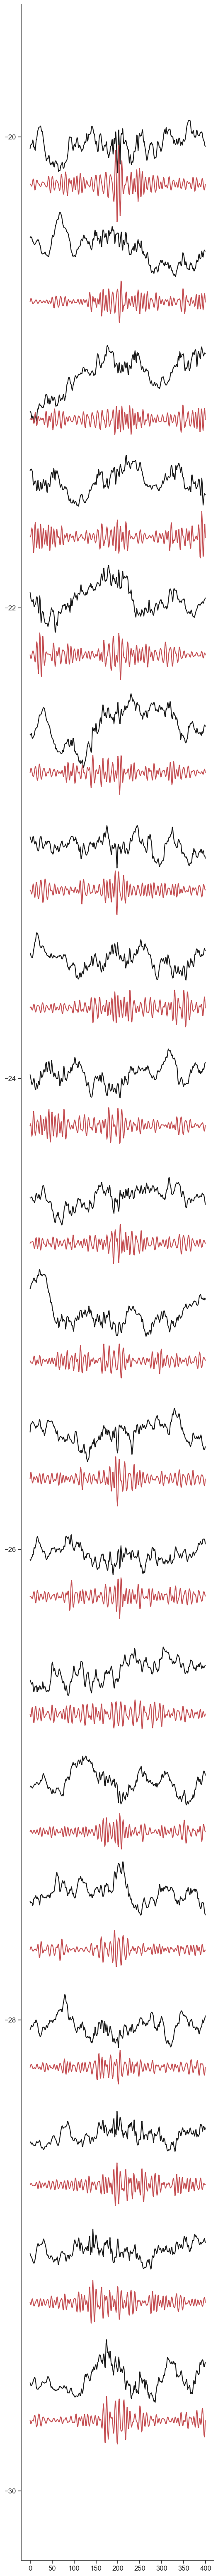

In [519]:
idx = np.arange(40,60)

plt.close('all')
plt.figure(figsize=(6,4*20))

for ii in idx:
    
    plt.plot(lfp[ii,:]-ii*0.5,'k-')
    plt.plot(rippleband[ii,:]*3-ii*0.5-0.2,'r-')

plt.axvline(200,color='gray',linestyle='-',lw=0.5)
# plt.savefig('Session %s, band %i to %i, channel %i, ripple example, aligned to ripple' % (date,band[0],band[1],channel))

In [663]:
def get_ripple(date, band, channel):

    all_peaks = import_ripple(date, band)
    lfp = np.zeros((all_peaks[channel].shape[0],400))
    rippleband = np.zeros((all_peaks[channel].shape[0],400))
    sos = butter(5, band, btype='bandpass', output='sos', fs=1000)
    
    for ii, peak in enumerate(all_peaks[channel]):
        
        lfp[ii,:], _ = get_signal(all_peaks, date, channel, time=np.arange(peak-200,peak+200), aligned = 0)
        preprocessed, _ = preprocess_LFP(lfp[ii,:])
        rippleband[ii,:] = sosfiltfilt(sos, preprocessed)
    
    return lfp, rippleband


In [725]:
rat_lfp, rat_ripple = get_ripple('032023', [150,250], 120)
nhp_lfp, nhp_ripple = get_ripple('032023', [80,180], 120)

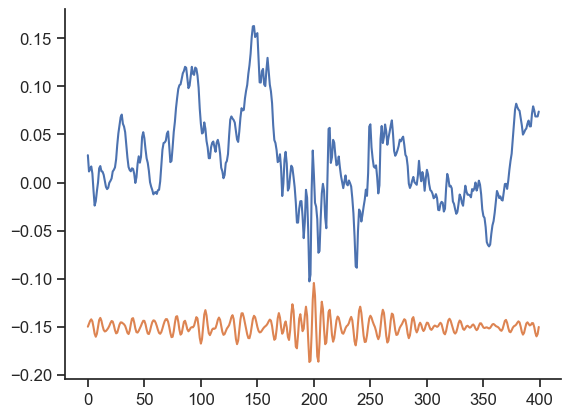

In [755]:
plt.close('all')
plt.plot(nhp_lfp[19,:])
plt.plot(nhp_ripple[19,:]-0.15)

In [743]:
# nhp_lfp, nhp_ripple = get_ripple('032823', [80,180], 180)
plot_ripple_spectrum('032023',120,)

ValueError: The length of the input vector x must be greater than padlen, which is 63.

In [721]:
def plot_ripple_spectrum(date,channel,lfp,idx):
    
    os.chdir('/Users/lianghexin/Documents/Berkeley/Teleworld/Code')
    
    for ii in idx:
            
        coefficients, freqs, power = wavelet(lfp[ii,:])
        zscored_power = (power-power.mean(axis=1)[:, None])/power.std(axis=1)[:, None]
        
        
        # 1. robust center: for each frequency, find the median 
        # center = np.nanmedian(power, axis=1)
        
        # # 2. fit on freq range that avoids narrowband peaks, e.g., 2-100 Hz:
        # use = (freqs >= 1) & (freqs <= 250)
        # coef = np.polyfit(freqs[use], np.log(center[use]), 1)
        # fit = np.exp(coef[0] * freqs + coef[1])
        
        # # 3. flatten
        # power_flat = power / fit[:, None]
        
        # Plot scalogram: time vs frequency with power as color
        plt.close('all')
        plt.figure(figsize=(8, 6))
        plt.contourf(np.arange(-200,200), freqs, zscored_power, 100, cmap='jet')
        # plt.yscale('log')
        # plt.ylim(20,80)
        plt.colorbar(label='Power')
        # plt.ylim(150,250)
        plt.axhline(80,color='w')
        plt.axhline(180,color='w')
        plt.xlim(-200,200)
        
        plt.xlabel('Time (ms)')
        plt.ylabel('Frequency (Hz)')
        plt.title('Band: %i - %i Hz' % (band[0],band[1]),fontsize=20)
        plt.tight_layout()
        plt.savefig('Session %s, band %i to %i, channel %i, ripple id %i' % (date,band[0],band[1],channel,ii))

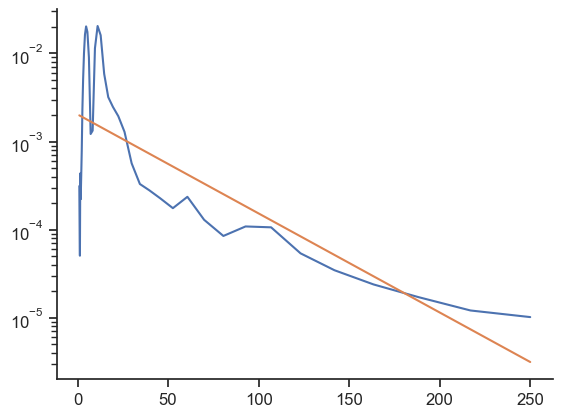

In [599]:
plt.close('all')
plt.semilogy(freqs,center)
plt.semilogy(freqs,fit)

In [659]:
# this looks like real ripple

date = '032023'
band = [80,180]
channel = 120

all_peaks = import_ripple(date, band)
lfp = np.zeros((all_peaks[channel].shape[0],400))
rippleband = np.zeros((all_peaks[channel].shape[0],400))
sos = butter(5, band, btype='bandpass', output='sos', fs=1000)

for ii, peak in enumerate(all_peaks[channel]):
    
    lfp[ii,:], _ = get_signal(all_peaks, date, channel, time=np.arange(peak-200,peak+200), aligned = 0)
    preprocessed, _ = preprocess_LFP(lfp[ii,:])
    rippleband[ii,:] = sosfiltfilt(sos, preprocessed)
    

plt.close('all')
plt.figure(figsize=(8,4))

for ii in [36]:
    
    plt.plot(lfp[ii,:]-ii*0.5,'k-')
    plt.plot(rippleband[ii,:]*3-ii*0.5-0.2,'r-')


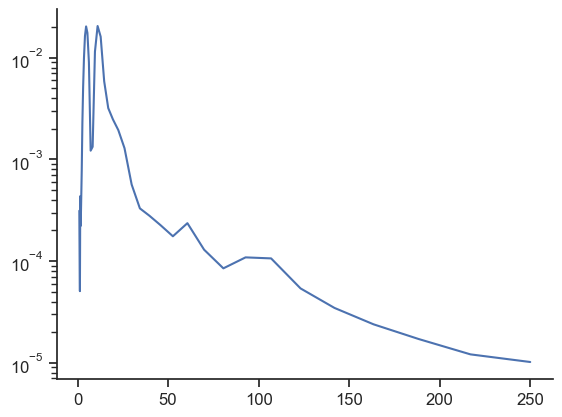

In [585]:
plt.close('all')
plt.semilogy(freqs,center)
plt.semilogy(freqs,fit)

In [539]:
def wavelet(sig, fs=1000):

    # notch filter 60hz and harmonics
    
    lfp_filt = sig.copy()
    for f0 in [60, 120, 180, 240]:# design 10th order band-stop (Butterworth) filter for each noise frequency +/- 2 Hz
        notchfilt = butter(10, (f0-2,f0+2), 'bandstop', fs=1000, output='sos')
        lfp_filt = sosfiltfilt(notchfilt, lfp_filt)

    t = np.arange(lfp.shape[1])
    p = np.polyfit(t, lfp_filt, deg=3)  # cubic fit
    trend = np.polyval(p, t)
    detrended = lfp_filt - trend

    
    # Define frequencies of interest (1 to 100 Hz, logarithmically spaced)
    freqs = np.logspace(np.log10(1), np.log10(250), num=40)
    
    # Convert frequencies to scales for Morlet wavelet in pywt
    # The formula depends on the wavelet center frequency:
    wavelet = 'cmor1.5-1.0'  # complex Morlet with bandwidth=1.5, center freq=1.0
    center_freq = pywt.central_frequency(wavelet)
    scales = center_freq * fs / freqs
    

    # Compute the Continuous Wavelet Transform (CWT)
    coefficients, frequencies = pywt.cwt(detrended, scales, wavelet, sampling_period=1/fs)
    
    # Compute power (magnitude squared of coefficients)
    power = np.abs(coefficients) ** 2

    return coefficients, frequencies, power

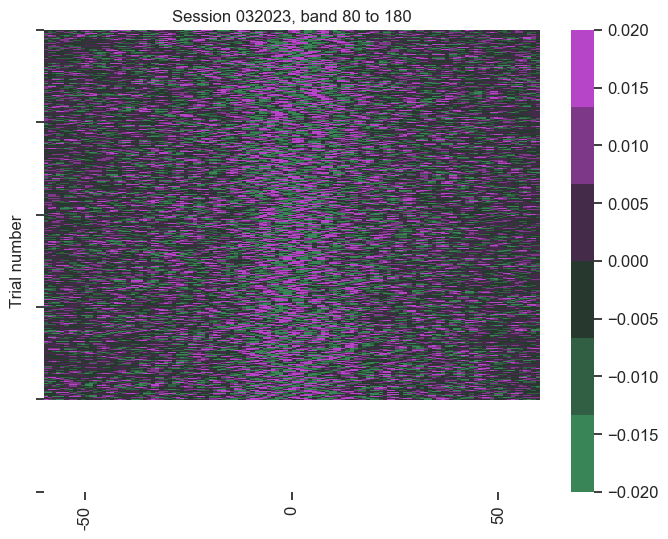

In [523]:
plt.close('all')
plt.figure(figsize=(8,6))
sns.heatmap(rippleband,vmin=-0.02,vmax=0.02, cmap = sns.diverging_palette(140,300,center='dark'))
plt.xlim(140,260)
plt.xticks(np.arange(150,260,50),labels=np.arange(-50,60,50))
plt.yticks(np.arange(0,560,100))
plt.ylabel('Trial number')
plt.title('Session %s, band %i to %i' % (date,band[0],band[1]))
plt.savefig('Session %s, band %i to %i, channel %i, ripple heatmap' % (date,band[0],band[1],channel))

In [191]:
lfp = get_signal('031723', 180, time=np.arange(4968976-20000,4968976+60000))
preprocessed, noise = preprocess_LFP(lfp,cutoff=4)
rippleband, smoothed, zscored, true_peaks, ons, offs = detect_ripple(preprocessed, noise, [80,180])

(-10.0, 20.0)

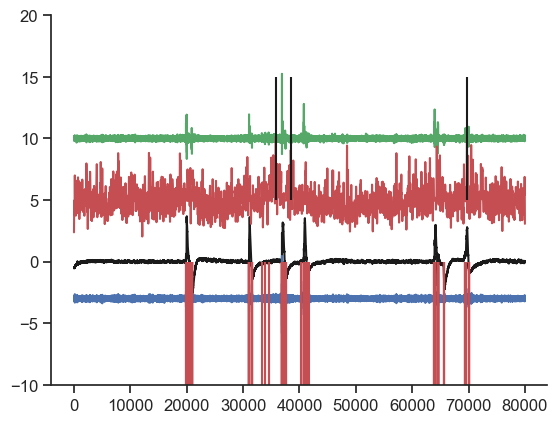

In [201]:
plt.close('all')
plt.plot(preprocessed,'k-')
plt.plot(zscored_diff/10+10,'g-')
plt.plot(rippleband*10-3)
plt.plot(zscored + 5,'r-')
plt.vlines(true_peaks,5,15,color='k',linestyle='-')
plt.vlines(noise,-10,0,color='r',linestyle='-')
# plt.xlim(69000,71000)
plt.ylim(-10,20)

In [17]:
def merge_close_neighbors(arr, threshold=50):
    
    arr = np.sort(np.array(arr, dtype=float))  # sort & ensure float
    merged = True

    while merged:
        
        merged = False
        new_arr = []
        skip_next = False

        for i in range(len(arr)):
            
            if skip_next:
                skip_next = False
                continue

            if i < len(arr) - 1 and abs(arr[i+1] - arr[i]) < threshold:
                
                # merge the two
                mean_val = (arr[i] + arr[i+1]) / 2
                new_arr.append(mean_val)
                skip_next = True
                merged = True
                
            else:
                new_arr.append(arr[i])

        arr = np.array(sorted(new_arr))
    
    return arr


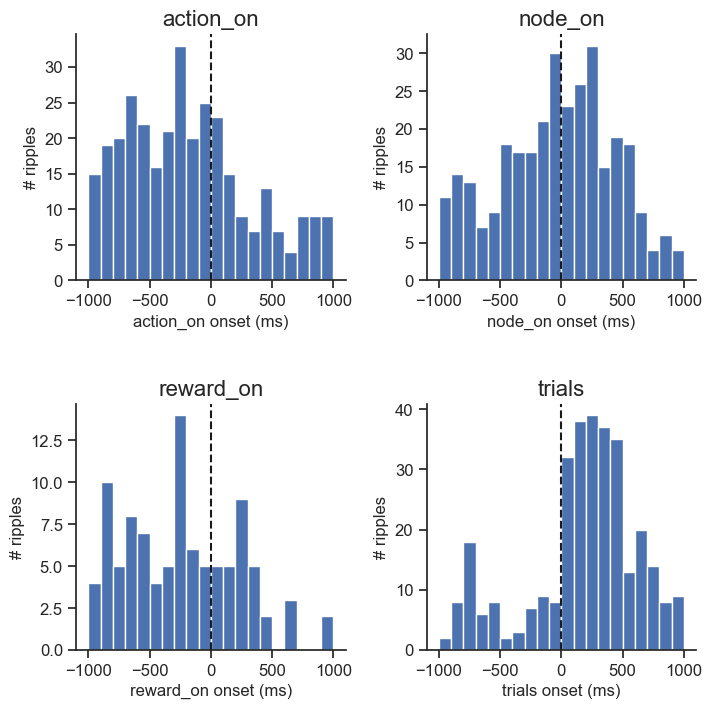

In [65]:
# aligned to behavior epochs, histogram counts

epochs = ['action_on', 'node_on', 'reward_on', 'trials']

plt.close('all')
fig, ax = plt.subplots(2,2,figsize=(8,8))


for ii, epoch in enumerate(epochs):
    
    df = nwbfile.intervals[epoch].to_dataframe() #.query('trialerror==1')
    df = df.loc[:,df.columns[:-1]]

    ripple_time = []
    starts = df.start_time.values
    ends = df.stop_time.values
    
    for tt in range(len(df)):
        
        rel_onset = (peaks[(peaks> starts[tt]-1000) & (peaks<ends[tt])]-starts[tt]).astype(int)
    
        ripple_time.append(rel_onset)

    
    ax[np.divmod(ii,2)].hist(np.concatenate(ripple_time),bins=np.arange(-1000,1100,100))
    ax[np.divmod(ii,2)].set_xlabel('%s onset (ms)' % epoch)
    ax[np.divmod(ii,2)].set_ylabel('# ripples')
    ax[np.divmod(ii,2)].set_title(epoch,fontsize=16)
    ax[np.divmod(ii,2)].axvline(0,color='k',linestyle='--')

fig.subplots_adjust(hspace=0.5, wspace=0.3)
# fig.savefig('Ripple counts, session %s' % date)

In [9]:
# dates = ['031723','032023','032823','033123','040423','040723']

dates = ['032023','032823','033123','040423','040723']


for date in dates:

    timestamps, lfpData, nwbfile = import_data(date)
    
    # check ripples across all channels
    
    num_ch = lfpData.shape[1]
    all_peaks = [[] for i in range(num_ch)]
    all_durs = [[] for i in range(num_ch)]
    
    for ch in tqdm(range(num_ch)):

        try:
            all_peaks[ch], all_durs[ch] = detect_ripple(timestamps,lfpData[:, ch],band=[150,250])
        except:
            pass
    
    
    peaks_obj = np.array(all_peaks, dtype=object)
    durs_obj = np.array(all_durs, dtype=object)
    np.savez('session ripples %s 150 to 250.npz' % date,
             peaks=peaks_obj,
             durs=durs_obj)

# os.chdir(Path('/Users/lianghexin/Documents/Berkeley/Teleworld/Code'))
# data = np.load('session 031723 ripples.npz', allow_pickle=True)
# all_peaks, all_durs = data['peaks'], data['durs']

100%|███████████████████████████████████████| 192/192 [1:58:47<00:00, 37.12s/it]


In [89]:
down_ts = timestamps[::10]
count_ripple = np.zeros((64,len(down_ts)))

for ii in range(64,64*2):
    
    temp = np.zeros(len(timestamps))
    temp[all_peaks[ii]]=1
    count_ripple[ii-64,:] = np.convolve(temp,np.ones(10),mode='same')[::10]

peaks = down_ts[count_ripple.sum(axis=0)>20]

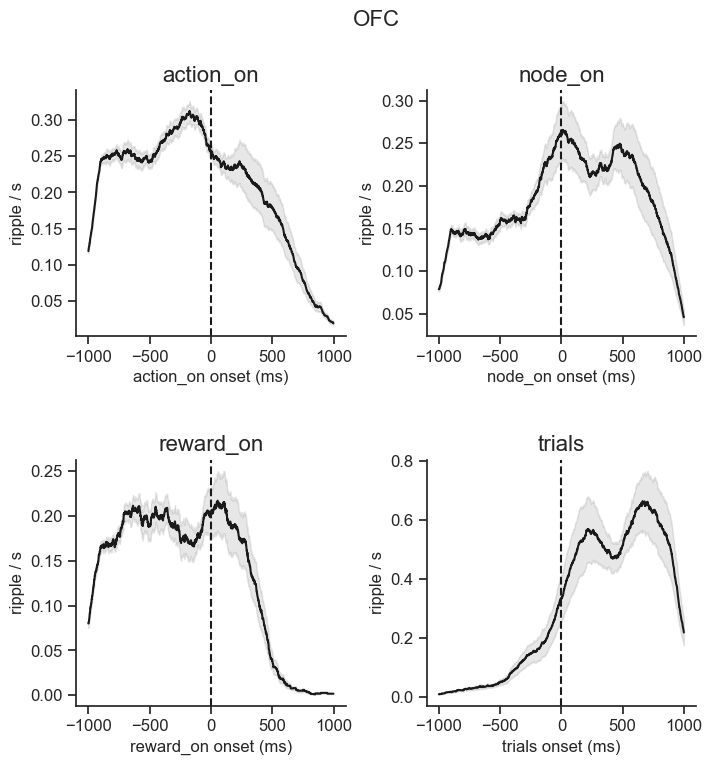

In [231]:
region = 'OFC'

plt.close('all')
fig, ax = plt.subplots(2,2,figsize=(8,8))

plot_ripple_rate_all("region==@region")

fig.subplots_adjust(hspace=0.5, wspace=0.3)
plt.suptitle(region,fontsize=16)
plt.savefig('%s ripple rate' % region)

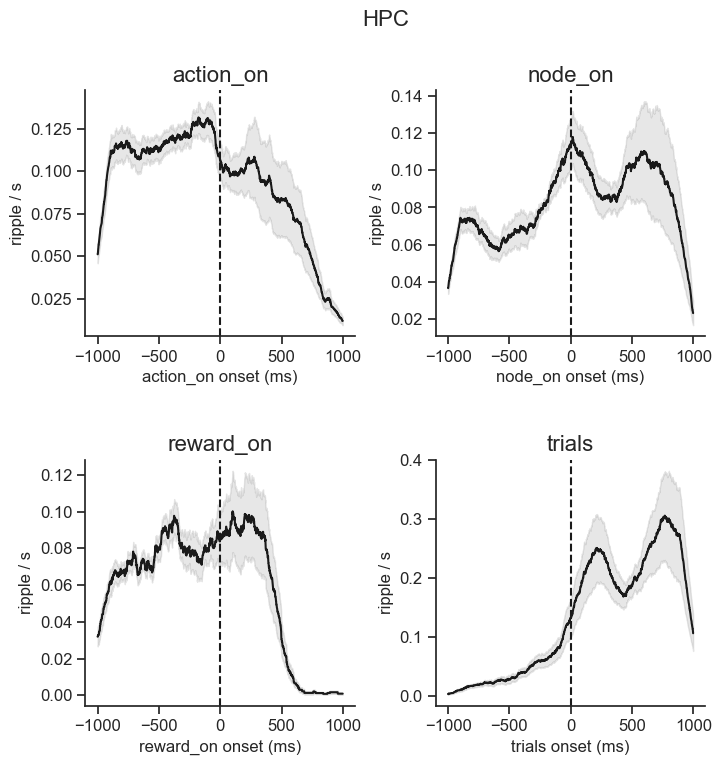

In [230]:
region = 'HPC'

plt.close('all')
fig, ax = plt.subplots(2,2,figsize=(8,8))

plot_ripple_rate_all("region==@region")

fig.subplots_adjust(hspace=0.5, wspace=0.3)
plt.suptitle(region,fontsize=16)
plt.savefig('%s ripple rate' % region)

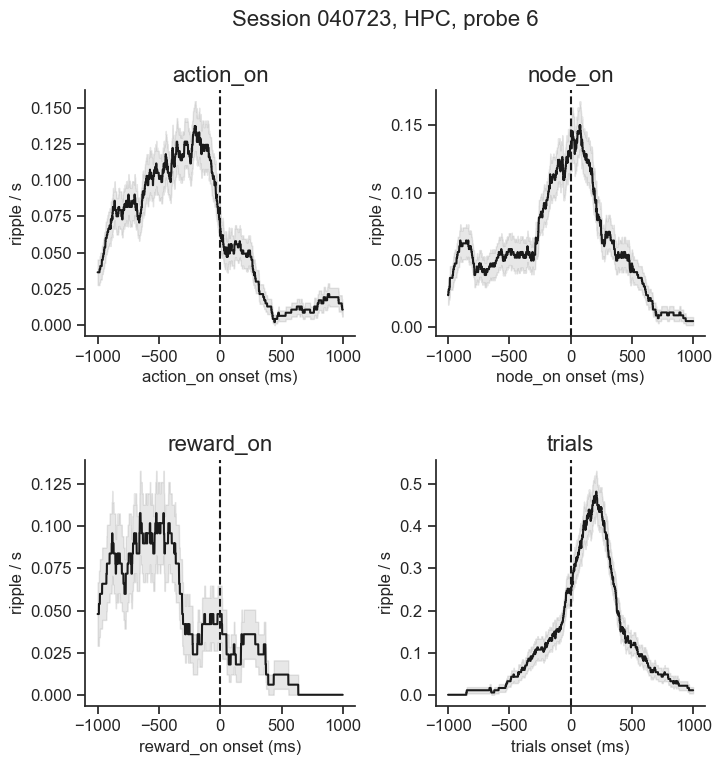

In [227]:
for pp in range(len(probe_info)):

    plt.close('all')
    fig, ax = plt.subplots(2,2,figsize=(8,8))
    
    plot_ripple_rate_single(probe_info.iloc[pp,:])
    date, region, probe = probe_info.iloc[pp,:][['date','region','probe']]
    
    fig.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.suptitle('Session 0%i, %s, probe %i' % (date,region,probe),fontsize=16)
    plt.savefig('Session 0%i, %s, probe %i, ripple rate' % (date,region,probe))

In [229]:
def plot_ripple_rate_all(query): 

    # aligned to behavior epochs, ripple rates
    
    epochs = ['action_on', 'node_on', 'reward_on', 'trials']
    df_region = probe_info.query(query)
    ripple_time_all = np.zeros((len(epochs),len(df_region),2000))
    
    for pp in range(len(df_region)):
        
        date = df_region.iloc[pp]['date']
        peaks = df_region.iloc[pp]['ripples']
        timestamps, lfpData, nwbfile = import_data('0%i' % date)
        
        for ii, epoch in enumerate(epochs):
            
            df = nwbfile.intervals[epoch].to_dataframe() #.query('trialerror==1')
            df = df.loc[:,df.columns[:-1]]
        
            ripple_time = np.zeros((len(df),2000))
            starts = df.start_time.values
            
            for tt in range(len(df)):
                
                rel_onset = (peaks[(peaks> starts[tt]-1000) & (peaks<starts[tt]+1000)]-(starts[tt]-1000)).astype(int)
            
                if len(rel_onset)>0:
                    ripple_time[tt,rel_onset] = 1
        
            ripple_time_all[ii,pp,:] = 1000*np.convolve(ripple_time.mean(axis=0),np.ones(200)/200,mode='same')
    
    
    for ii, epoch in enumerate(epochs):
        
        ripple_rate = ripple_time_all[ii,:,:]
        ripple_mean = ripple_rate.mean(axis=0)
        ripple_sem = ripple_rate.std(axis=0)/np.sqrt(ripple_rate.shape[0])
    
        ax[np.divmod(ii,2)].plot(np.arange(-1000,1000),ripple_mean,color='k')
        ax[np.divmod(ii,2)].fill_between(np.arange(-1000,1000), ripple_mean-ripple_sem, ripple_mean+ripple_sem,color='k',alpha=0.1)
        ax[np.divmod(ii,2)].set_xlabel('%s onset (ms)' % epoch)
        ax[np.divmod(ii,2)].set_ylabel('ripple / s')
        ax[np.divmod(ii,2)].set_title(epoch,fontsize=16)
        ax[np.divmod(ii,2)].axvline(0,color='k',linestyle='--')
        


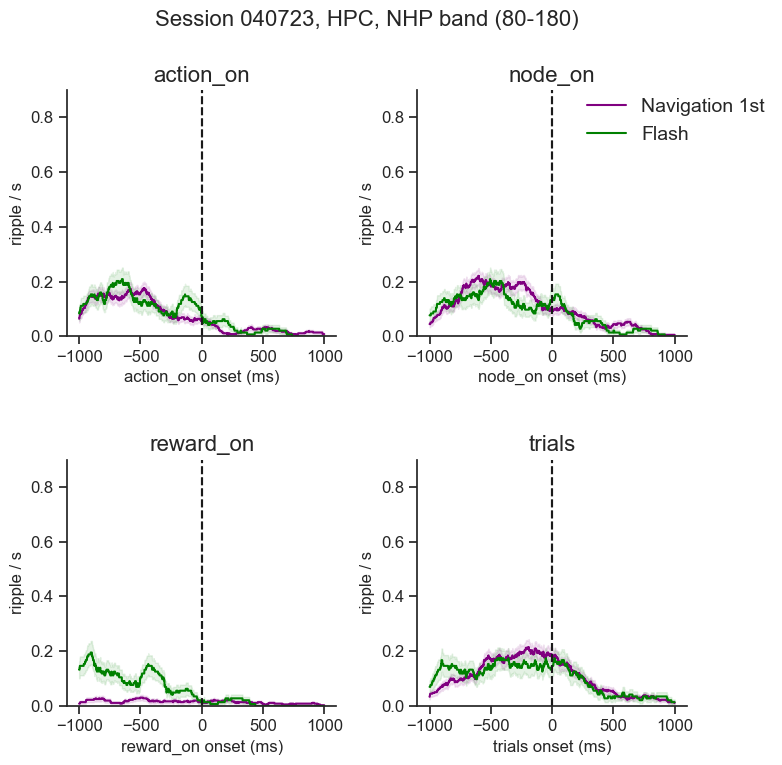

In [57]:
# planning first v.s. cued

region = 'HPC'

dates = ['031723','032023','032823','033123','040423','040723']

ylims = [0.8, 0.9, 1.3, 1.2, 1.1, 0.9]

for ii,dd in enumerate(dates):

    date = int(dd[1:])
    
    plt.close('all')
    fig, ax = plt.subplots(2,2,figsize=(8,8))
    
    ripple_time_all = plot_ripple_rate_date("(region==@region) & (date==@date)",
                                            "(trialerror==0) & (step==0)",'purple', ylims[ii],
                                           epochs = ['action_on', 'node_on'])
    
    ripple_time_all = plot_ripple_rate_date("(region==@region) & (date==@date)",
                                            "(trialerror==0) ",'purple',ylims[ii],
                                           epochs = ['', '', 'reward_on','trials'])

    ripple_time_all = plot_ripple_rate_date("(region==@region) & (date==@date)","trialerror==1",
                                            'green',ylims[ii],
                                            epochs = ['action_on', 'node_on', 'reward_on','trials'])
    

    ax[0,1].plot([0,0],[0,0],color='purple',label='Navigation 1st')
    ax[0,1].plot([0,0],[0,0],color='green',label='Flash')
    ax[0,1].legend(frameon=False,loc=(0.6,0.75),fontsize=14)
    
    fig.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.suptitle('Session 0%i, %s, NHP band (80-180)' % (date,region),fontsize=16)
    plt.savefig('Session 0%i, %s, ripple rate NHP, planning 1st vs cue' % (date,region))


In [31]:
def add_ripple_to_probe(band,neighbor=5):

    probe_info = pd.read_excel('/Users/lianghexin/Documents/Berkeley/Teleworld/Code/Bart Probe Info for Hexin.xlsx')

    ripples = []
    
    for pp in range(len(probe_info)):
        
        start_ch = probe_info.iloc[pp]['start_channel']
        end_ch = probe_info.iloc[pp]['end_channel']
        date = probe_info.iloc[pp]['date']
        
        all_peaks = import_ripple('0'+str(date), band)
        timestamps,_ = import_LFP('0'+str(date))
        
        down_ts = timestamps[::10]
        count_ripple = np.zeros((32,len(down_ts)))
            
        for ii in range(start_ch-1,end_ch):
            
            temp = np.zeros(len(timestamps))
            temp[all_peaks[ii-1]]=1
            count_ripple[ii-start_ch+1,:] = np.convolve(temp,np.ones(10),mode='same')[::10]
    
        peaks = np.round(down_ts[count_ripple.sum(axis=0)>neighbor],decimals=2)
        ripples.append(merge_close_neighbors(peaks))
    
    probe_info['ripples'] = ripples

    return probe_info

In [57]:
rat_ripples = add_ripple_to_probe([150,250])
nhp_ripples = add_ripple_to_probe([80,180])

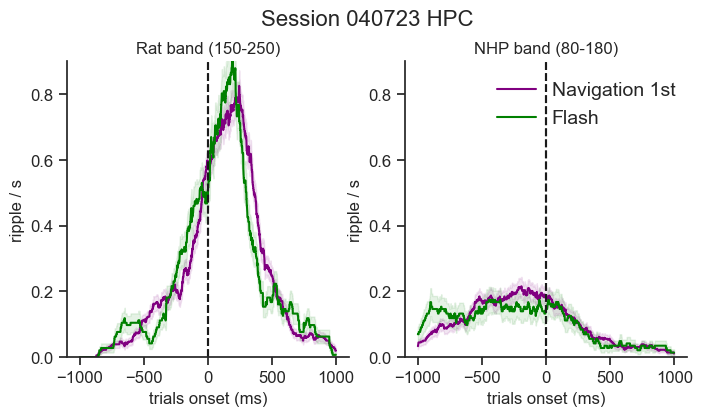

In [71]:
# planning first v.s. cued, trials on 

region = 'HPC'

dates = ['031723','032023','032823','033123','040423','040723']
ylims = [0.8, 0.9, 1.3, 1.2, 1.1, 0.9]

rat_ripple_time_all_nav = [[] for ii in range(6)]
rat_ripple_time_all_flash = [[] for ii in range(6)]
nhp_ripple_time_all_nav = [[] for ii in range(6)]
nhp_ripple_time_all_flash = [[] for ii in range(6)]

for ii, dd in enumerate(dates):

    date = int(dd[1:])
    
    plt.close('all')
    fig, ax = plt.subplots(1,2,figsize=(8,4))
    
    
    rat_ripple_time_all_nav = plot_ripple_rate_date(rat_ripples, "(region==@region) & (date==@date)",
                                            "(trialerror==0) ",'purple', ylims[ii], ax[0],
                                           epochs = ['trials'])
    rat_ripple_time_all_flash = plot_ripple_rate_date(rat_ripples, "(region==@region) & (date==@date)",
                                            "(trialerror==1) ",'green', ylims[ii], ax[0],
                                           epochs = ['trials'])
    ax[0].set_title('Rat band (150-250)')
    
    
    nhp_ripple_time_all_nav = plot_ripple_rate_date(nhp_ripples, "(region==@region) & (date==@date)",
                                            "(trialerror==0) ",'purple', ylims[ii], ax[1],
                                           epochs = ['trials'])
    nhp_ripple_time_all_flash = plot_ripple_rate_date(nhp_ripples, "(region==@region) & (date==@date)",
                                            "(trialerror==1) ",'green', ylims[ii], ax[1],
                                           epochs = ['trials'])
    ax[1].set_title('NHP band (80-180)')
    ax[1].plot([0,0],[0,0],color='purple',label='Navigation 1st')
    ax[1].plot([0,0],[0,0],color='green',label='Flash')
    ax[1].legend(frameon=False,loc=(0.3,0.75),fontsize=14)

    fig.subplots_adjust(top=0.85)  # reduce the top space used by subplots
    plt.suptitle('Session 0%i %s' % (date,region),fontsize=16)
    plt.savefig('Session 0%i, %s, rat vs NHP, planning 1st vs cue' % (date,region))


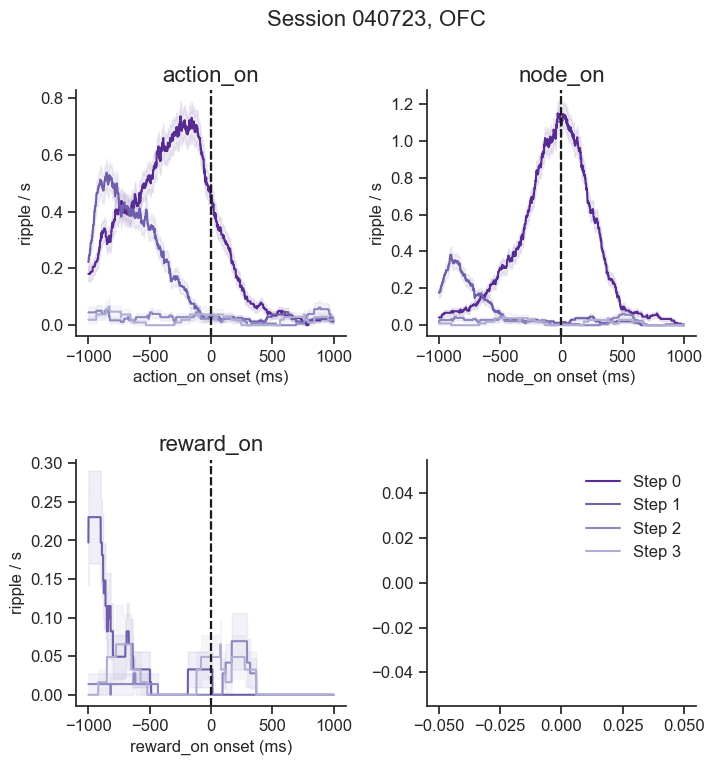

In [324]:
# planning step

region = 'OFC'

dates = ['031723','032023','032823','033123','040423','040723']
colors = sns.color_palette('Purples_r',6)[:4]

for dd in dates:

    date = int(dd[1:])
    
    plt.close('all')
    fig, ax = plt.subplots(2,2,figsize=(8,8))
    
    for step in range(4):
        ripple_time_all = plot_ripple_rate_date("(region==@region) & (date==@date)",
                                                "(trialerror==0) & (step==@step)",colors[step],
                                               epochs = ['action_on', 'node_on', 'reward_on'])
    
        ax[1,1].plot([0,0],[0,0],color=colors[step],label='Step %i' % step)
    
    ax[1,1].legend(frameon=False)
    
    fig.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.suptitle('Session 0%i, %s' % (date,region),fontsize=16)
    plt.savefig('Session 0%i, %s, ripple rate, planning by step' % (date,region))



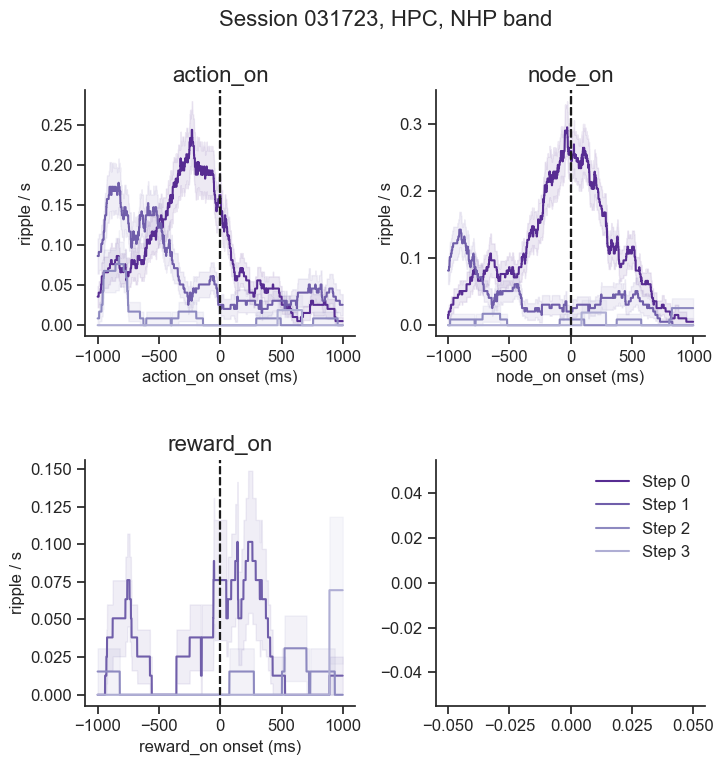

In [71]:
# planning step

region = 'HPC'

dates = ['031723','032023','032823','033123','040423','040723']
dates = ['031723']

colors = sns.color_palette('Purples_r',6)[:4]

for dd in dates:

    date = int(dd[1:])
    
    plt.close('all')
    fig, ax = plt.subplots(2,2,figsize=(8,8))
    
    for step in range(4):
        ripple_time_all = plot_ripple_rate_date("(region==@region) & (date==@date)",
                                                "(trialerror==0) & (step==@step)",colors[step],
                                               epochs = ['action_on', 'node_on', 'reward_on'])
    
        ax[1,1].plot([0,0],[0,0],color=colors[step],label='Step %i' % step)
    
    ax[1,1].legend(frameon=False)
    
    fig.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.suptitle('Session 0%i, %s, NHP band' % (date,region),fontsize=16)
    plt.savefig('Session 0%i, %s, ripple rate, planning by step, NHP band' % (date,region))



In [51]:
def plot_ripple_rate_date(probe_info,ripple_query,beh_query,color,ylim,ax,epochs = ['action_on', 'node_on', 'reward_on', 'trials']): 

    # aligned to behavior epochs, ripple rates
    
    df_region = probe_info.query(ripple_query)
    ripple_time_all = [[] for _ in range(len(epochs))]
    
    for pp in range(len(df_region)):
        
        date = df_region.iloc[pp]['date']
        peaks = df_region.iloc[pp]['ripples']
        
        timestamps,_ = import_LFP('0'+str(date))
        nwbfile = import_behavior('0%i' % date)
        
        for ii, epoch in enumerate(epochs):

            if epoch!='':
            
                df = nwbfile.intervals[epoch].to_dataframe().query(beh_query)
                df = df.loc[:,df.columns[:-1]]
    
                if len(df)>0:
                
                    ripple_time = np.zeros((len(df),2000))
                    starts = df.start_time.values
                    
                    for tt in range(len(df)):
                        
                        rel_onset = (peaks[(peaks> starts[tt]-1000) & (peaks<starts[tt]+1000)]-(starts[tt]-1000)).astype(int)
                    
                        if len(rel_onset)>0:
                            ripple_time[tt,rel_onset] = 1
        
                        ripple_time_all[ii].append(1000*np.convolve(ripple_time[tt,:],np.ones(200)/200,mode='same'))
            
    
    for ii, epoch in enumerate(epochs):

        if len(ripple_time_all[ii])>0:
        
            ripple_rate = np.array(ripple_time_all[ii])
            ripple_mean = ripple_rate.mean(axis=0)
            ripple_sem = ripple_rate.std(axis=0)/np.sqrt(ripple_rate.shape[0])
        
            ax.plot(np.arange(-1000,1000),ripple_mean,color=color)
            ax.fill_between(np.arange(-1000,1000), ripple_mean-ripple_sem, ripple_mean+ripple_sem,color=color,alpha=0.1)
            ax.set_xlabel('%s onset (ms)' % epoch)
            ax.set_ylabel('ripple / s')
            ax.set_ylim(0,ylim)
            ax.set_title(epoch,fontsize=16)
            ax.axvline(0,color='k',linestyle='--')
        

    # if len(epochs)<4:
        
    #     for spine in ax[1,1].spines.values():
    #         spine.set_visible(False)
        
    #     # Remove ticks and labels
    #     ax[1,1].set_xticks([])
    #     ax[1,1].set_yticks([])
    
    return ripple_time_all

In [223]:
def plot_ripple_rate_single(df_region): 

    # aligned to behavior epochs, ripple rates
    
    epochs = ['action_on', 'node_on', 'reward_on', 'trials']
    ripple_time_all = np.zeros((len(epochs),len(df_region),2000))
        
    date = df_region['date']
    peaks = df_region['ripples']
    timestamps, lfpData, nwbfile = import_data('0%i' % date)
    
    for ii, epoch in enumerate(epochs):
        
        df = nwbfile.intervals[epoch].to_dataframe() #.query('trialerror==1')
        df = df.loc[:,df.columns[:-1]]
    
        ripple_time = np.zeros((len(df),2000))
        starts = df.start_time.values
        
        for tt in range(len(df)):
            
            rel_onset = (peaks[(peaks> starts[tt]-1000) & (peaks<starts[tt]+1000)]-(starts[tt]-1000)).astype(int)
        
            if len(rel_onset)>0:
                ripple_time[tt,rel_onset] = 1
                ripple_time[tt,:] = 1000*np.convolve(ripple_time[tt,:],np.ones(200)/200,mode='same')
    
        ripple_mean = ripple_time.mean(axis=0)
        ripple_sem = ripple_time.std(axis=0)/np.sqrt(ripple_time.shape[0])
    
        ax[np.divmod(ii,2)].plot(np.arange(-1000,1000),ripple_mean,color='k')
        ax[np.divmod(ii,2)].fill_between(np.arange(-1000,1000), ripple_mean-ripple_sem, ripple_mean+ripple_sem,color='k',alpha=0.1)
        ax[np.divmod(ii,2)].set_xlabel('%s onset (ms)' % epoch)
        ax[np.divmod(ii,2)].set_ylabel('ripple / s')
        ax[np.divmod(ii,2)].set_title(epoch,fontsize=16)
        ax[np.divmod(ii,2)].axvline(0,color='k',linestyle='--')
        


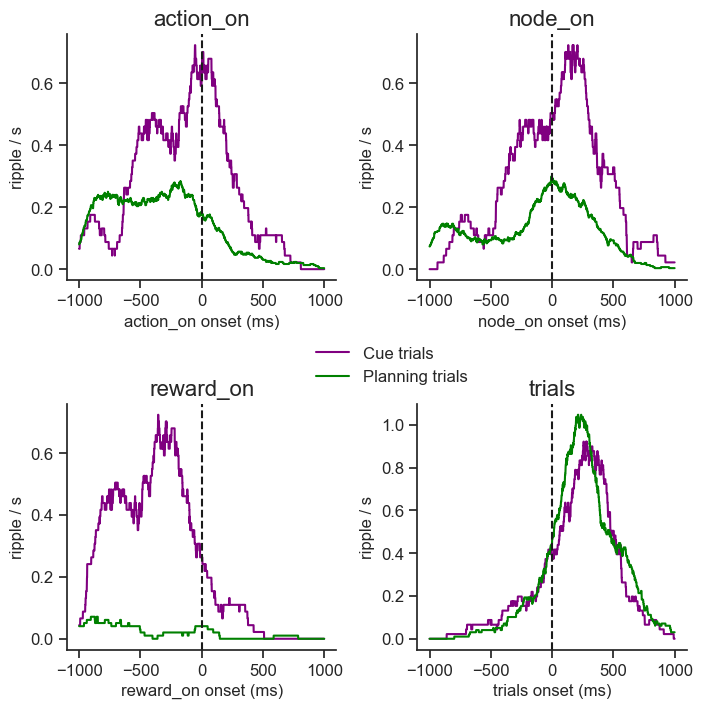

In [75]:
# aligned to behavior epochs, ripple rates, separate for cue and planning trials

epochs = ['action_on', 'node_on', 'reward_on', 'trials']

plt.close('all')
fig, ax = plt.subplots(2,2,figsize=(8,8))


for ii, epoch in enumerate(epochs):
    
    df_both = nwbfile.intervals[epoch].to_dataframe() 
    df = df_both.loc[:,df_both.columns[:-1]].query('trialerror==1')

    ripple_time = np.zeros((len(df),2000))
    starts = df.start_time.values
    
    for tt in range(len(df)):
        
        rel_onset = (peaks[(peaks> starts[tt]-1000) & (peaks<starts[tt]+1000)]-(starts[tt]-1000)).astype(int)
    
        if len(rel_onset)>0:
            ripple_time[tt,rel_onset] = 1

    
    ax[np.divmod(ii,2)].plot(np.arange(-1000,1000),1000*np.convolve(ripple_time.mean(axis=0),np.ones(200)/200,mode='same'),
                             color='purple',label='Cue trials')


    df = df_both.loc[:,df_both.columns[:-1]].query('trialerror==0')

    ripple_time = np.zeros((len(df),2000))
    starts = df.start_time.values
    
    for tt in range(len(df)):
        
        rel_onset = (peaks[(peaks> starts[tt]-1000) & (peaks<starts[tt]+1000)]-(starts[tt]-1000)).astype(int)
    
        if len(rel_onset)>0:
            ripple_time[tt,rel_onset] = 1

    
    ax[np.divmod(ii,2)].plot(np.arange(-1000,1000),1000*np.convolve(ripple_time.mean(axis=0),np.ones(200)/200,mode='same'),
                             color='green',label='Planning trials')
    
    ax[np.divmod(ii,2)].set_xlabel('%s onset (ms)' % epoch)
    ax[np.divmod(ii,2)].set_ylabel('ripple / s')
    ax[np.divmod(ii,2)].set_title(epoch,fontsize=16)
    ax[np.divmod(ii,2)].axvline(0,color='k',linestyle='--')

plt.legend(loc=(-0.4,1.05),frameon=False)
fig.subplots_adjust(hspace=0.5, wspace=0.3)
# fig.savefig('Ripple rate, cue vs planning, session %s' % date)

/var/folders/vp/0ygvp9fj4dj79f756hg2wnwc0000gn/T/ipykernel_1877/895323967.py:27: RuntimeWarning: Mean of empty slice.
  ax[ii].plot(np.arange(-1000,1000),1000*np.convolve(ripple_time.mean(axis=0),np.ones(200)/200,mode='same'),
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


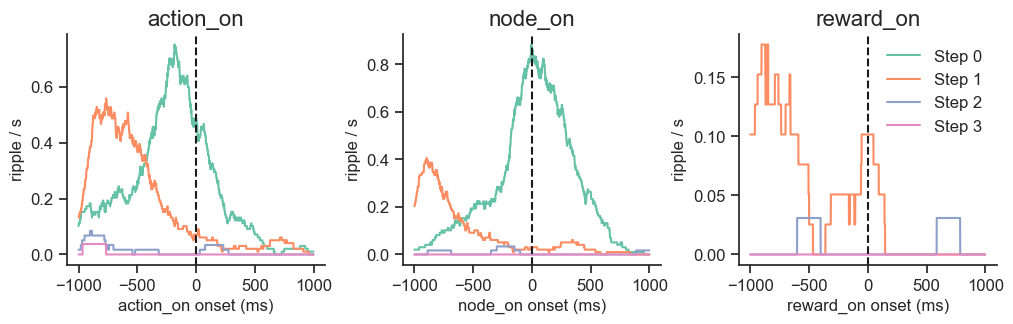

In [77]:
# aligned to behavior epochs, ripple rates, separate for each step in planning trials

epochs = ['action_on', 'node_on', 'reward_on']

plt.close('all')
fig, ax = plt.subplots(1,3,figsize=(12,3))


for ii, epoch in enumerate(epochs):
    
    df_both = nwbfile.intervals[epoch].to_dataframe() 

    for step in range(4):

        df = df_both.loc[:,df_both.columns[:-1]].query('(step==@step) & (trialerror==0)')
        ripple_time = np.zeros((len(df),2000))
        starts = df.start_time.values
        
        for tt in range(len(df)):
            
            rel_onset = (peaks[(peaks> starts[tt]-1000) & (peaks<starts[tt]+1000)]-(starts[tt]-1000)).astype(int)
        
            if len(rel_onset)>0:
                ripple_time[tt,rel_onset] = 1
    
        
        ax[ii].plot(np.arange(-1000,1000),1000*np.convolve(ripple_time.mean(axis=0),np.ones(200)/200,mode='same'),
                                 color=sns.color_palette('Set2',6)[step],label='Step %i' % step)

    
    ax[ii].set_xlabel('%s onset (ms)' % epoch)
    ax[ii].set_ylabel('ripple / s')
    ax[ii].set_title(epoch,fontsize=16)
    ax[ii].axvline(0,color='k',linestyle='--')
    
    if ii==2:
        ax[ii].legend(frameon=False)
    
fig.subplots_adjust(hspace=0.5, wspace=0.3)
# fig.savefig('Ripple rate, step number, session %s' % date)

/var/folders/vp/0ygvp9fj4dj79f756hg2wnwc0000gn/T/ipykernel_1877/4257358488.py:42: RuntimeWarning: Mean of empty slice.
  ax[ii].plot(np.arange(-1000,1000),1000*np.convolve(ripple_time.mean(axis=0),np.ones(200)/200,mode='same'),
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


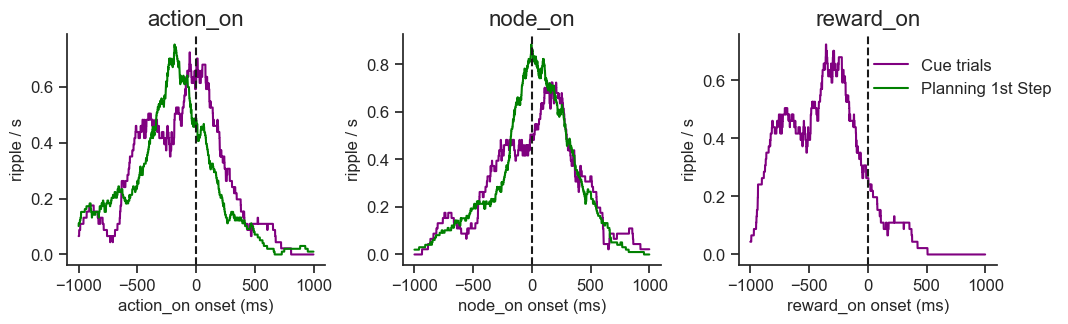

In [79]:
# aligned to behavior epochs, ripple rates, compare first step in planning trials and cue trials

epochs = ['action_on', 'node_on', 'reward_on']

plt.close('all')
fig, ax = plt.subplots(1,3,figsize=(12,3))


for ii, epoch in enumerate(epochs):
    
    df_both = nwbfile.intervals[epoch].to_dataframe() 


    df = df_both.loc[:,df_both.columns[:-1]].query('trialerror==1')
    ripple_time = np.zeros((len(df),2000))
    starts = df.start_time.values
    
    for tt in range(len(df)):
        
        rel_onset = (peaks[(peaks> starts[tt]-1000) & (peaks<starts[tt]+1000)]-(starts[tt]-1000)).astype(int)
    
        if len(rel_onset)>0:
            ripple_time[tt,rel_onset] = 1

    
    ax[ii].plot(np.arange(-1000,1000),1000*np.convolve(ripple_time.mean(axis=0),np.ones(200)/200,mode='same'),
                             color='Purple',label='Cue trials')

    
    df = df_both.loc[:,df_both.columns[:-1]].query('(step==0) & (trialerror==0)')
    ripple_time = np.zeros((len(df),2000))
    starts = df.start_time.values
    
    for tt in range(len(df)):
        
        rel_onset = (peaks[(peaks> starts[tt]-1000) & (peaks<starts[tt]+1000)]-(starts[tt]-1000)).astype(int)
    
        if len(rel_onset)>0:
            ripple_time[tt,rel_onset] = 1

    
    ax[ii].plot(np.arange(-1000,1000),1000*np.convolve(ripple_time.mean(axis=0),np.ones(200)/200,mode='same'),
                             color='Green',label='Planning 1st Step')

    
    ax[ii].set_xlabel('%s onset (ms)' % epoch)
    ax[ii].set_ylabel('ripple / s')
    ax[ii].set_title(epoch,fontsize=16)
    ax[ii].axvline(0,color='k',linestyle='--')
    
    if ii==2:
        ax[ii].legend(loc=(0.5,0.7),frameon=False)
    
fig.subplots_adjust(hspace=0.5, wspace=0.3)
# fig.savefig('Ripple rate, cue vs planning 1st, session %s' % date)

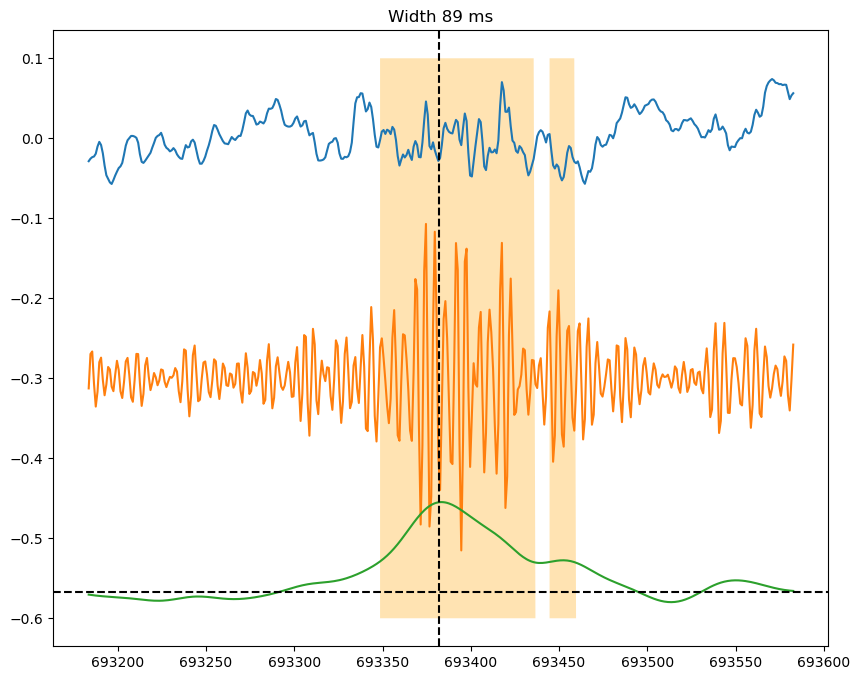

In [370]:
# check individual ripple event

# for ii,peak in enumerate(peaks):
ii=101
peak=peaks[ii]
idx = np.arange(peak-200,peak+200)
chunk = dataset[idx, 16]
plt.close('all')
plt.figure(figsize=(10,8))
plt.plot(ts[idx],chunk)
plt.plot(ts[idx],filtered[idx]*10-0.3)
plt.plot(ts[idx],smoothed[idx]*10-0.6)
plt.axhline(smoothed.mean()*10-0.6,color='k',linestyle='--')
plt.axvline(peak,color='k',linestyle='--')
plt.title('Width %i ms' % widths[ii])

plt.fill_between(
    ts[idx].ravel(),-0.6,0.1,
    where=zscored[idx] > 3,
    interpolate=True,
    facecolor='orange',
    alpha=0.3,
    label='Above Threshold'
)

# plt.ylim(-0.5,1.5)
# plt.axhline(3)
# plt.xlim(6,7)

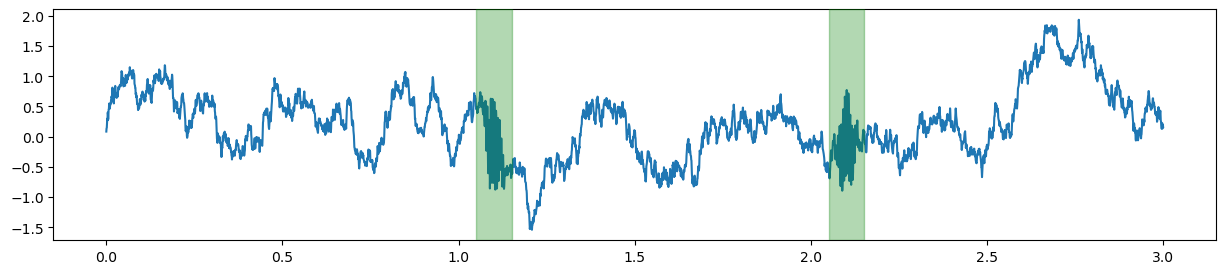

In [12]:
from ripple_detection.simulate import simulate_LFP

true_ripple_midtime = [1.1, 2.1]
RIPPLE_DURATION = 0.100
lfps = simulate_LFP(
    time, true_ripple_midtime, noise_amplitude=1.2, ripple_amplitude=1.5
)[:, np.newaxis]
speed = np.ones_like(time)

fig, ax = plt.subplots(figsize=(15, 3))
plt.plot(time, lfps)


for midtime in true_ripple_midtime:
    plt.axvspan(
        midtime - RIPPLE_DURATION / 2,
        midtime + RIPPLE_DURATION / 2,
        alpha=0.3,
        color="green",
        zorder=1000,
    )

In [ ]:
filtered_lfps = filter_ripple_band(x)

ripple_times = Kay_ripple_detector(
    time, filtered_lfps, speed, SAMPLING_FREQUENCY
)

display(ripple_times)

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(time, lfps)

for midtime in true_ripple_midtime:
    ax.axvspan(
        midtime - RIPPLE_DURATION / 2,
        midtime + RIPPLE_DURATION / 2,
        alpha=0.3,
        color="green",
        zorder=9,
    )

for ripple in ripple_times.itertuples():
    ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color="red", zorder=10)